## Predviđanje strukture *RNK*<a id="par:toc"></a>

U radu je razmotrena primena [probabilističkih kontekstno slobodnih gramatika](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar) (*PCFG*) i [konvolutivnih neuronskih mreža](https://en.wikipedia.org/wiki/Convolutional_neural_network) (*CNN*) u predviđanju sekundarne strukture [ribonukleinske kiseline](https://en.wikipedia.org/wiki/RNA) (*RNK*). Preuzet je skup *RNK* sa pridruženim strukturama, nakon čega je na delu podataka obučena po jedna stohastička gramatika i duboka konvolutivna mreža. Modeli su vrednovani prema uspehu na drugom delu podataka, odnosno sličnosti predviđanja sa stvarnošću.

## Sadržaj

1. [Uvod i podaci](#par:uvod)  
    1.1 [Struktura *RNK*](#par:strukt)  
    1.2 [Predikcija strukture](#par:pred)  
    1.3 [Skup *RNAStralign*](#par:baza)  
    1.4 [Olakšani problem](#par:olak)
2. [Stohastičke gramatike](#par:stoh)  
    2.1 [Odabir gramatike](#par:kh99)  
    2.2 [Stablo izvođenja](#par:stablo)  
    2.3 [Obuka gramatike](#par:obkh)
3. [Duboka konvolucija](#par:konv)  
    3.1 [Shema pristupa](#par:shema)  
    3.2 [Matrica strukture](#par:mstr)  
    3.3 [Matrica sekvence](#par:msek)  
    3.4 [Priprema paketa](#par:paket)  
    3.5 [Odabir arhitekture](#par:cnn)  
    3.6 [Sumarizacija](#par:suma)  
    3.7 [Obuka filtera](#par:obcnn)  
    3.8 [Validacija obuke](#par:val)
4. [Evaluacija modela](#par:eval)  
    4.1 [Najbolje stablo](#par:maks)  
    4.2 [Najbolje uparivanje](#par:maku)  
    4.3 [Mere kvaliteta](#par:mere)  
    4.4 [Predviđanja](#par:enkap)  
    4.5 [Ukupni uspeh](#par:rez)
5. [Zaključak](#par:zaklj)

## 1. Uvod i podaci [⮭]<a id="par:uvod"></a>

[⮭]: #par:toc

Obrađeni zadatak podrazumeva predviđanje sekundarne strukture ribonukleinske kiseline, pa je za početak predstavljen kratak teorijski osvrt na strukturu *RNK*, a zatim na njenu predikciju. Nadalje je opisan referentni skup podataka *RNAStralign*, koji je korišćen prilikom modelovanja. Naposletku je problem olakšan ograničavanjem samo na kratke sekvence, kako bi se izbegli problemi sa računskom zahtevnošću, ali uz zadržavanje biološkog smisla zadatka.

### 1.1 Struktura *RNK* [⮭]<a id="par:strukt"></a>

[⮭]: #par:uvod

*RNK* je biopolimer čiju [primarnu strukturu](https://en.wikipedia.org/wiki/Nucleic_acid_sequence) gradi niz [nukleobaza](https://en.wikipedia.org/wiki/Nucleobase). U sastav sekvence ulaze četiri kanonske nukleobaze – [adenin](https://en.wikipedia.org/wiki/Adenine), [uracil](https://en.wikipedia.org/wiki/Uracil), [guanin](https://en.wikipedia.org/wiki/Guanine) i [citozin](https://en.wikipedia.org/wiki/Cytosine). Računarski gledano, *RNK* se stoga najčešće predstavlja kao niska nad azbukom $\{A, U, C, G\}$, što je skup početnih slova navedenih baza.

<img src='../slike/primarna.png' width='40%'>

Specijalno, sekvencu mogu činiti i drugi karakteri, koji predstavljaju [modifikovane baze](https://en.wikipedia.org/wiki/Nucleobase#Modified_nucleobases). Tako, na primer, [pseudouridin](https://en.wikipedia.org/wiki/Pseudouridine) ($P$) predstavlja izmenjeni [uridin](https://en.wikipedia.org/wiki/Uridine) ($U$). Ovakva modifikovanost ne doprinosi problemu predviđanja strukture i najčešće se zanemaruje, te nije ni predstavljena u poznatim bazama podataka.

Kako bi prešla u biološki aktivnu formu, *RNK* se [uvija intramolekularno](https://en.wikipedia.org/wiki/Nucleic_acid_structure), čime formira segmente uparenih nukleobaza. Takvi segmenti nazivaju se zavojnicama (*helix*) ili drškama (*stem*), dok nizovi neuparenih baza grade petlje (*loop*). U zavisnosti od oblika, postoji više različitih vrsta petlji: ukosnica (šnala, *hairpin*), unutrašnja (*interior*), razgranata (*multi-branched*), ispupčenje (*bulge*). Posebno se izdvaja i spoljašnji nestrukturirani lanac (*unstructured single strand*).

<img src='../slike/sekundarna.png' width='70%'>

Uvijanje se najčešće vizuelizuje u formi [grafa](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29), pri čemu su čvorovi baze, dok grane postoje između uparenih baza (označene kružićima ili lukovima), kao i između susednih elemenata sekvence (implicitne, neoznačene). Pored realističnog prikaza (*c*), popularni su i oni koji sekvencu predstavljaju na jednoj pravoj (*a*) ili na kružnici (*b*). Oni su značajni jer svedoče o ugnežđenosti uparivanja. Važan je i prikaz u formi matrice povezanosti (*d*), o čemu će biti reči u nastavku.

<img src='../slike/vizuelizacija.png' width='90%'>

Ovako formirani [bazni parovi](https://en.wikipedia.org/wiki/Base_pair) upravo čine [sekundarnu strukturu](https://en.wikipedia.org/wiki/Nucleic_acid_secondary_structure) *RNK*. Parovi $A−U$ i $G−C$ pritom su kanonski (prema Votsonu i Kriku), mada su moguće i neke [nekanonske](https://en.wikipedia.org/wiki/Non-canonical_base_pairing) varijante uparivanja, pri čemu se kao treći posebno izdvaja nešto manje stabilan ([*wobble*](https://en.wikipedia.org/wiki/Wobble_base_pair)), ali i dalje termodinamički povoljan par $U−G$.

<img src='../slike/familija.png' width='60%'>

Osim u formi grafa ili prostog spiska parova, sekundarnu strukturu moguće je predstaviti i kao nisku, i to nad azbukom koja se sastoji od [tačke i zagrada](https://eprints.soton.ac.uk/267292/1/RamlanEI08ExtDotBracRNA.pdf). U ovakvoj notaciji, tačka predstavlja neuparenu bazu, dok zagrade označavaju parove. Uparivanje baza, očekivano, prati matematičko i jezičko pravilo uparivanja zagrada. Podrazumevano, niske koje predstavljaju primarnu (sekvencu) i sekundarnu (uparivanje) strukturu iste *RNK* moraju biti saglasne.

<img src='../slike/pseudocvor.png' width='40%'>

U sastav sekundarne strukture ulazi nekoliko značajnih motiva. Posebno je zanimljiv strukturni motiv [ukosnice sa drškom](https://en.wikipedia.org/wiki/Stem-loop) (*stem-loop*), koji karakteriše sve ukosnice. Njegova važna odlika je da petlja sadrži najmanje tri baze, što je ograničenje koje je neophodno ugraditi u računarske metode. [Pseudočvorovi](https://en.wikipedia.org/wiki/Pseudoknot) su još jedna znamenita pojava, budući da predstavljaju neugnežđena uparivanja. Oni, međutim, zadiru u [tercijarnu](https://en.wikipedia.org/wiki/Nucleic_acid_tertiary_structure) i [kvaternarnu](https://en.wikipedia.org/wiki/Nucleic_acid_quaternary_structure) strukturu, koje nisu razmatrane.

### 1.2 Predikcija strukture [⮭]<a id="par:pred"></a>

[⮭]: #par:uvod

Problem [predviđanja strukture](https://en.wikipedia.org/wiki/Nucleic_acid_structure_prediction) *RNK* značajan je utoliko što je ona u tesnoj vezi sa funkcijom same kiseline, pa su njenom predikcijom zapravo predviđene mnogobrojne karakteristike razmatrane sekvence. Osim toga, eksperimentalno [utvrđivanje](https://en.wikipedia.org/wiki/Nucleic_acid_structure_determination) tačne strukture je skupo, pa se poseže za računarskim metodama.

Osnovni pristup rešavanju ovog problema zasniva se na pronalaženju strukture sa najviše baznih parova i naziva se [algoritam Nusinov](https://en.wikipedia.org/wiki/Nussinov_algorithm), prema autorki. Datira iz 1980. godine, kada je objavljen rad [*Fast algorithm for predicting the secondary structure of single-stranded RNA*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC350273/). Sam algoritam vrlo je jednostavan i svodi se na [dinamičko programiranje](https://en.wikipedia.org/wiki/Dynamic_programming). Prosta maksimizacija, međutim, ne uzima u obzir važne strukturne karakteristike *RNK*, pa u praksi nije preterano uspešna.

<img src='../slike/nussinov.jpg' width='60%'>

Alternativni pristup zasniva se na činjenici da intramolekularno uvijanje *RNK* diktiraju biofizički procesi, odnosno da je optimalna struktura ona sa [najnižom slobodnom energijom](https://en.wikipedia.org/wiki/Principle_of_minimum_energy) (*MFE*). Najsofisticiraniji metod tog tipa jeste Zukerov termodinamički model, predstavljen 1989. kroz rad [*Improved predictions of secondary structures for RNA*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC298139/), a zatim dorađivan nekoliko puta, što je kulminiralo objavom alata [*mfold*](https://academic.oup.com/nar/article/31/13/3406/2904217) 2003. godine. Kasnije je objavljen veći broj sličnih alata.

<img src='../slike/zuker.png' width='50%'>

Paralelno sa termodinamičkim modelima razvijali su se oni zasnovani na statističkom učenju. Prvo su se pojavile stohastičke kontekstno slobodne gramatike, koje su zapravo duže vreme korišćene u obradi prirodnih jezika. Možda najuticajniji pristup iz tog domena jeste algoritam *KH-99*, koji su 1999. kroz rad [*RNA secondary structure prediction using stochastic context-free grammars and evolutionary history*](https://pubmed.ncbi.nlm.nih.gov/10383470/) uveli Knudsen i Hejn. Nakon dorada, 2003. je objavljen alat [*Pfold*](https://pubmed.ncbi.nlm.nih.gov/12824339/). Ubrzo je došlo do objedinjavanja termodinamičkih i statističkih modela, što je u svoje vreme bila kombinacija [vrhunske tehnologije](https://en.wikipedia.org/wiki/State_of_the_art) (*state of the art*).

Poslednjih godina su veliku popularnost stekle metode [dubokog učenja](https://en.wikipedia.org/wiki/Deep_learning), zasnovanog na različitim [veštačkim neuronskim mrežama](https://en.wikipedia.org/wiki/Artificial_neural_network). One su sada vrhunska tehnologija za rešavanje velikog broja problema, pa tako i predviđanja sekundarne strukture *RNK*. Uz probabilističke kontekstno slobodne gramatike, upravo su duboke konvolutivne neuronske mreže glavna tema ovog rada. U nastavku su modeli oba tipa obučeni, evaluirani i upoređeni prema stepenu uspeha.

### 1.3 Skup *RNAStralign* [⮭]<a id="par:baza"></a>

[⮭]: #par:uvod

Manjak podataka o *RNK* dugo je pravio problem pri radu sa njima. Početkom 21. veka bilo je poznato tek nekoliko hiljada različitih sekvenci, pri čemu znatno manje struktura. Poslednjih godina, međutim, eksperimentalno je utvrđen način uvijanja velikog broja novootkrivenih [nekodirajućih](https://en.wikipedia.org/wiki/Non-coding_RNA) ribonukleinskih kiselina.

Trenutno najpoznatija baza *RNK* sa pridruženim strukturama jeste skup podataka *RNAStralign*, objavljen 2017. godine u okviru rada [*TurboFold II: RNA structural alignment and secondary structure prediction informed by multiple homologs*](https://pubmed.ncbi.nlm.nih.gov/29036420/). Ovaj skup sadrži $37.149$ struktura iz osam različitih familija *RNK* − [*16S*](https://en.wikipedia.org/wiki/16S_ribosomal_RNA) ribozomalne, [*5S*](https://en.wikipedia.org/wiki/5S_ribosomal_RNA) ribozomalne, [katalitički introni](https://en.wikipedia.org/wiki/Group_I_catalytic_intron) (*Group I Intron*), [ribonukleaze](https://en.wikipedia.org/wiki/Ribonuclease_P) (*RNaseP*), [signalne](https://en.wikipedia.org/wiki/Signal_recognition_particle_RNA) (*SRP*), [telomeraze](https://en.wikipedia.org/wiki/Telomerase), [transportno-informacione](https://en.wikipedia.org/wiki/Transfer-messenger_RNA) (*tmRNA*), [transportne](https://en.wikipedia.org/wiki/Transfer_RNA) (*tRNA*) − čija dužina varira od nekoliko desetina do skoro dve hiljade nukleobaza. Dužina, struktura i familija inače su u tesnoj vezi.

Skup *RNAStralign* sadrži identifikator sekvence, samu sekvencu, njenu familiju, kao i strukturu u obliku niza uparivanja, pri čemu indeks $j$ kao $i$-ti element niza svedoči o postojanju uparivanja $(i, j)$. Ukoliko postoji uparivanje $(i, j)$ postoji i obrnuto $(j, i)$ koje je isto. U slučaju $i = j$, baza je neuparena. Iako vrlo koristan, ovaj skup sadrži redundantne podatke. Postoje, naime, suštinski ponovljene strukture, budući da se ista ili slična *RNK* pojavljuje u više organizama. Zbog toga se pristupa uklanjanju redundantnosti kao vidu čišćenja podataka, nakon čega ostaje $30.451$ instanci. Na ovaj način dobija se [referentni](https://en.wikipedia.org/wiki/Benchmark_%28computing%29) (*benchmark*) skup, uveden u radu [*RNA Secondary Structure Prediction By Learning Unrolled Algorithms*](https://arxiv.org/abs/2002.05810) (*E2Efold*) iz 2020, a koji se koristi za upoređivanje različitih pristupa.

Dodatnim zanemarivanjem nepotpunih sekvenci, čija struktura nije precizno određena, dobija se konačan broj od $28.473$ sloga. Pomenuti rad preporučuje [podelu](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) na skupove za obučavanje (trening), proveru (test) i validaciju u približnom odnosu $80\%−10\%−10\%$, i to [stratifikovanu](https://en.wikipedia.org/wiki/Stratified_sampling) prema familiji. Štaviše, oni su dostupni kroz tri datoteke u formatu zapetom razdvojenih vrednosti, pa se u nastavku sveske koriste kao `train.csv`, `test.csv` i `valid.csv`. Sledi implementacija klase koja enkapsulira *RNK* sekvencu sa pridruženim identifikatorom, familijom i strukturom, a može i da je nacrta, kao i učita podatke.

In [1]:
# Biblioteka za crtanje
from ipynb.draw import draw_struct

# Biblioteka za vizuelizacije
from matplotlib import pyplot as plt

In [2]:
# Niska strukture od uparivanja
def niska_od_niza(uparivanje):
    # Inicijalizacija strukture
    struktura = len(uparivanje) * ['.']

    # Popunjavanje strukture uparivanjima
    for i, j in enumerate(uparivanje):
        if i < j:
            struktura[i] = '('
            struktura[j] = ')'
    
    # Spajanje strukture u jednu nisku
    return ''.join(struktura)

In [3]:
# Klasa koja predstavlja RNK
class RNK:
    # Konstrukcija objekta prema podacima
    def __init__(self, identifikator, sekvenca, familija, *uparivanje):
        # Identifikator, sekvenca, familija
        # prosto se prepisuju bez izmena
        self.id = identifikator
        self.sekvenca = sekvenca
        self.familija = familija
        
        # Uparivanje se mapira u indekse
        self.uparivanje = [*map(int, uparivanje)]
        
        # Poništavanje susednih uparivanja
        for i, j in enumerate(self.uparivanje):
            if abs(i-j) < 3:
                self.uparivanje[i] = i
                self.uparivanje[j] = j
        
        # Struktura se čuva i kao niska
        self.struktura = niska_od_niza(self.uparivanje)
    
    # Crtanje enkapsulirane sekundarne strukture
    def _ipython_display_(self):
        draw_struct(self.sekvenca, self.struktura, ax=plt.gca())
        
        # Dodavanje naslova ilustraciji
        plt.title('\n'.join([f'{self.id} [{self.familija}]', self.sekvenca,
                             self.struktura]), fontdict={'family': 'monospace'})
        
        # Sređivanje grafikona
        plt.tight_layout()
    
    # Učitavanje podataka iz datoteke
    def učitaj(datoteka):
        with open(datoteka) as f:
            return [RNK(*l.split(',')) for l in f.readlines()]

In [4]:
# Učitavanje skupova sa diska
train = RNK.učitaj('../podaci/train.csv')
test = RNK.učitaj('../podaci/test.csv')
valid = RNK.učitaj('../podaci/valid.csv')

Nakon učitavanja, korisno je [analizirati](https://en.wikipedia.org/wiki/Exploratory_data_analysis) podatke. Za početak, tabelarno je predstavljena raspodela instanci po familijama i skupovima za trening, test i validaciju. Najzastupljenije su ribozomalna i transportna *RNK*, dok telomeraza ima simbolično malo. Podela stvarno jeste stratifikovana. Prikazane su i statistike koje se odnose na dužinu sekvenci unutar familije. Ubedljivo je najkraća transportna, a isto tako ubedljivo najduža *16S* ribozomalna *RNK*.

In [5]:
# Biblioteka za rad sa nizovima
import numpy as np

# Biblioteka za rad sa tabelama
import pandas as pd

# Biblioteka za grupisanje instanci
from itertools import groupby

In [6]:
# Spisak dostupnih skupova podataka
skupovi = 'svi', 'train', 'test', 'valid'

# Spisak osam familija koje su deo baze
familije = np.unique([rnk.familija for rnk in valid])

# Spojeni spisak za potrebe analize skupa
svi = sorted(train + test + valid, key=lambda rnk: rnk.familija)

# Spisak zanimljivih statistika
agregacije = 'min', 'max', 'mean', 'std'

In [7]:
# Grupisanje instanci po familiji
def po_familiji(podaci):
    return groupby(globals()[podaci], lambda rnk: rnk.familija)

# Statistika nad odabranim skupom
def statistika(funkcija, skup):
    return [getattr(np, funkcija)
            ([len(rnk.sekvenca) for rnk in familija])
            for _, familija in po_familiji(skup)]

In [8]:
# Tabelarni prikaz raspodele familija
def tabela_familija():
    # Inicijalno prazna tabela raspodele
    tabela = pd.DataFrame(index=familije)
    
    # Brojčana zastupljenost svake familije po skupovima
    for skup in skupovi:
        tabela[skup] = statistika('count_nonzero', skup)
    
    # Statistike svake familije u spojenom skupu
    for agg in agregacije:
        tabela[agg] = statistika(agg, 'svi')
    
    # Sortiranje tabele prema zastupljenosti familije
    tabela.sort_values(by='svi', ascending=False, inplace=True)
    
    # Sumiranje po familijama u specijalni red
    for skup in skupovi:
        tabela.loc[' ', skup] = tabela[skup].sum()
    
    # Statistike po familijama u specijalni red
    for agg in agregacije:
        tabela.loc[' ', agg] = getattr(tabela[agg], agg)()
    
    # Prikaz generisane celobrojne tabele
    display(tabela.astype(np.int32))

In [9]:
# Tabelarni prikaz raspodele familija
tabela_familija()

,svi,train,test,valid,min,max,mean,std
16S_rRNA_database,9792,7742,1023,1027,54,1829,1210,373
5S_rRNA_database,9706,7593,1069,1044,104,132,118,3
tRNA_database,7112,5387,858,867,64,95,76,5
group_I_intron_database,773,597,88,88,163,615,397,69
SRP_database,448,348,52,48,30,533,256,94
tmRNA_database,448,364,44,40,32,437,352,65
RNaseP_database,157,128,17,12,189,486,349,61
telomerase_database,37,29,4,4,382,559,444,37
,28473,22188,3155,3130,30,1829,400,119


Tabela prikazuje apsolutnu raspodelu instanci po familijama. S druge strane, moguće je iskoristiti [pitu](https://en.wikipedia.org/wiki/Pie_chart) kako bi se prikazala relativna raspodela. U nastavku je, jednostavnosti radi, prikazana pita samo za spojeni skup, ali iz prethodne tabele je jasno da bi identično izgledala na tri stratifikovano podeljena skupa.

In [10]:
# Pitičast prikaz raspodele familija
def pita_familija():
    # Brojčana zastupljenost svake familije
    zastupljenost = np.array(statistika('count_nonzero', 'svi'))
    
    # Relativna zastupljenost iz brojčane
    zastupljenost = zastupljenost / zastupljenost.sum()
    
    # Pita koja prikazuje relativnu zastupljenost
    kriške, _ = plt.pie(zastupljenost)
    
    # Oznake sa nazivom familije i njenim udelom
    oznake = [f'{i} [{j:.2%}]' for i, j in zip(familije, zastupljenost)]
    
    # Sortiranje kriški i oznaka prema zastupljenosti
    kriške, oznake, _ =  zip(*sorted(zip(kriške, oznake, zastupljenost),
                                     key=lambda x: x[2], reverse=True))
    
    # Ucrtavanje legende van pite zbog preklapanja
    plt.legend(kriške, oznake, bbox_to_anchor=(0, .75))
    
    # Sređivanje grafikona
    plt.tight_layout()

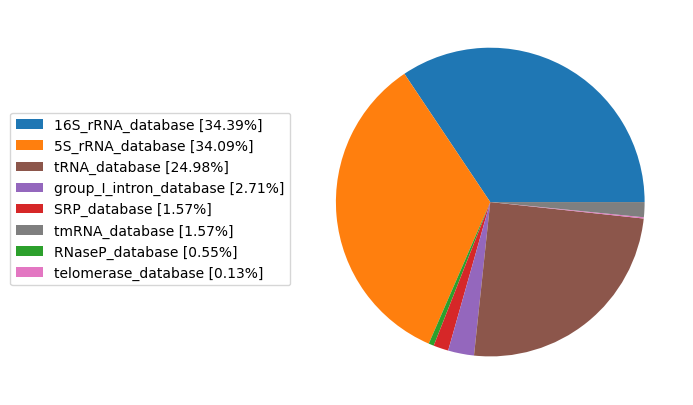

In [11]:
# Pitičast prikaz raspodele familija
pita_familija()

Kako je prikazana raspodela familija, tako se može prikazati i raspodela dužina sekvenci. To je najpogodnije uraditi upotrebom [histograma](https://en.wikipedia.org/wiki/Histogram). Iz ovog prikaza jasno je da tri podeljena skupa nisu stratifikovana samo po familiji, već i po dužini sekvenci. Jasno se izdvajaju najduže *16S* ribozomalne *RNK*, čija je prosečna dužina sekvence preko hiljadu nukleobaza. Jasno se izdvajaju i sekvence do stotinak nukleobaza, koje mahom pripadaju transportnoj *RNK*.

In [12]:
# Histogram raspodele dužina
def histogram_dužina():
    # Spiskovi dužina u svakom skupu
    dužine = [[len(rnk.sekvenca)
               for rnk in globals()[skup]]
               for skup in skupovi]
    
    # Pravljenje podgrafika za skupove
    fig, axs = plt.subplots(2, 2, figsize=(9, 4),
                            sharex=True, sharey=True)
    
    # Prolazak kroz sve skupove
    for ax, dužina, skup in zip(axs.ravel(), dužine, skupovi):
        # Histogram gustine tekućeg skupa
        ax.hist(dužina, density=True)
        
        # Ime skupa kao naslov histograma
        ax.set_title(skup)
    
    # Sređivanje grafikona
    fig.tight_layout()

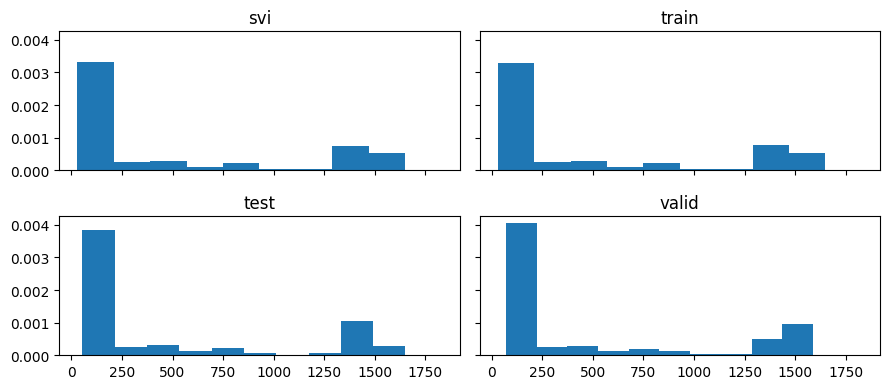

In [13]:
# Histogram raspodele dužina
histogram_dužina()

### 1.4 Olakšani problem [⮭]<a id="par:olak"></a>

[⮭]: #par:uvod

Kako je već nagovešteno, postoji tesna veza između dužine *RNK* sekvence, njene strukture i familije kojoj pripada. Stoga je čest motiv u literaturi pravljenje ansambla modela koji su trenirani nad sekvencama različitih dužina. Ispostavlja se da oni daju primetno bolje rezultate od pojedinačnog modela nad celim skupom. U ansamblu, dakle, postoji jedan model za sekvence kraće od neke trocifrene granice, a drugi za duže, mahom kompleksnu ribozomalnu *RNK*.

<img src='../slike/transportna.jpg' width='45%'>

U nastavku je, zbog toga, fokus samo na jednoj familiji, i to transportnoj *RNK*, skraćeno nazvanoj *tRNK*. Ova familija najčešće se modeluje kao [detelina s tri lista](https://en.wikipedia.org/wiki/Cloverleaf_model_of_tRNA), mada to nije sasvim precizna karakterizacija. Ima ulogu u [prenošenju](https://en.wikipedia.org/wiki/Translation_%28biology%29) aminokiselina i njihovoj ugradnji u proteine čija je sinteza u toku. Odabrana je prvenstveno zbog toga što je najkraća, što umnogome smanjuje računsku zahtevnost obučavanja i provere modela. Obučeni modeli mogli bi se koristiti u okviru ansambla za predviđanje strukture kratkih sekvenci, pogotovu ako je poznato da predstavljaju *tRNK*. Prikazan je jedan primer iz skupa za obuku.

In [14]:
# Odabir familije transportnih RNK
odabrane_familije = 'tRNA_database',

In [15]:
# Odabir familije nad učitanim skupovima
train = [rnk for rnk in train if rnk.familija in odabrane_familije]
test = [rnk for rnk in test if rnk.familija in odabrane_familije]
valid = [rnk for rnk in valid if rnk.familija in odabrane_familije]

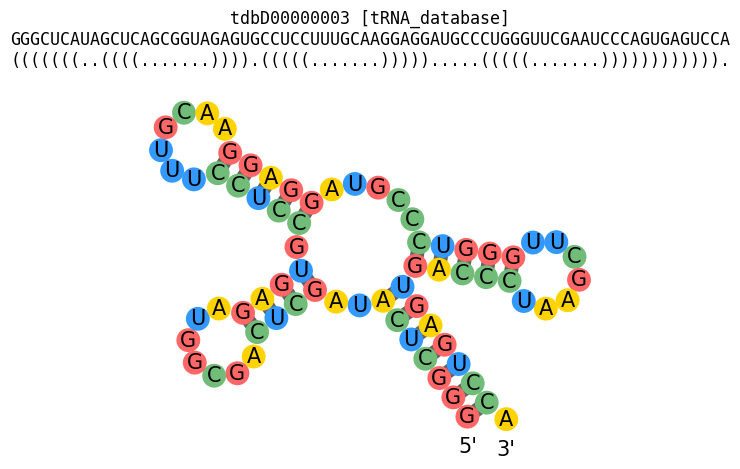

In [16]:
# Ilustracija strukture jedne tRNK
train[0]

Modeli koji su razmatrani u nastavku formiraju glomazne pomoćne strukture na osnovu sekvence, kao što su stabla i kvadratne matrice. Kako bi lakše mogli da se isprate ti koraci, uvodi se veštački primer dužine trideset nukleobaza. Ovaj primer ima znatno manje baza, ali strukturno odgovara transportnoj *RNK*.

In [17]:
# Mali primer sekvence
primer = RNK('Mali primer', 'GUUAGCAUCGCGGGAACCUUUGGAACCAUG', 'tRNK',
             28, 27, 2, 3, 10, 9, 6, 7, 8, 5, 4, 11, 17, 16, 14, 15,
             13, 12, 18, 19, 20, 26, 25, 23, 24, 22, 21, 1, 0, 29)

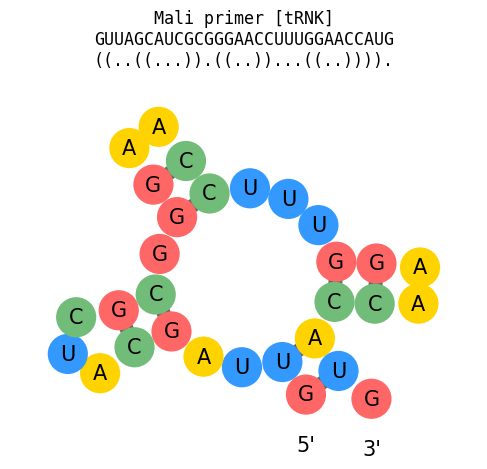

In [18]:
# Struktura malog primera
primer

## 2. Stohastičke gramatike [⮭]<a id="par:stoh"></a>

[⮭]: #par:toc

[Formalna gramatika](https://en.wikipedia.org/wiki/Formal_grammar) određena je konačnim skupom simbola i pravila izvođenja. Simboli mogu biti apstraktni neterminali (nezavršni), ali i konkretni terminali (završni), koji se pojavljuju u rečenicama modelovanog jezika. Terminali u slučaju *RNK* odgovaraju već pomenutoj azbuci nukleobaza $\{A, U, C, G\}$, dok skup neterminala zavisi od gramatike, ali obavezno sadrži početni neterminal $S$ (kao *start*). Pravila izvođenja data su u obliku $\alpha \rightarrow \beta$, gde su $\alpha$ i $\beta$ nizovi simbola.

Kontekstno slobodne gramatike odlikuje ograničenje da je leva strana pravila ($\alpha$) strogo jedan neterminal, dok je desna ($\beta$) proizvoljan niz simbola. Stohastičke gramatike dodatno svakom pravilu izvođenja pridružuju verovatnoću, i to dobro definisanu, tako da je pokriven ceo prostor događaja, odnosno da se verovatnoća svih mogućih izvođenja iz jednog neterminala sumira u jedinicu. Ispostavlja se da stohastičke ili [probabilističke kontekstno slobodne gramatike](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar) (*PCFG*), koja objedinjuju ove dve odlike, predstavljaju dobar statistički model jezika sa ugnežđenim zavisnostima, a takav je upravo razmatrani jezik *RNK*.

### 2.1 Odabir gramatike [⮭]<a id="par:kh99"></a>

[⮭]: #par:stoh

Kako je napomenuto u uvodu, *PCFG* su uz termodinamičke modele dugo bile vrhunski pristup predviđanju sekundarne strukture ribonukleinskih kiselina. Pritom se *KH-99* izdvaja kao jedna od najuticajnijih i najuspešnijih gramatika, pa je upravo ona implementirana u nastavku. Gramatika je sledećeg oblika:

$$ \large S → LS \scriptsize\text{ (nizanje elemenata) } \large| L \scriptsize\text{ (poslednji element) } $$
$$ \large L → s \scriptsize\text{ (neuparena baza) } \large| dFd \scriptsize\text{ (početak zavojnice) } $$
$$ \large F → dFd \scriptsize\text{ (nastavak zavojnice) } \large| LS \scriptsize\text{ (unutrašnjost zavojnice) } $$

Pored obaveznog startnog simbola $S$, od kog počinje izvođenje nizanjem elemenata, ova jednostavna gramatika sadrži još samo dva neterminala, koji prirodno modeluju uvijanje *RNK*. Neterminal $L$ (*loop*) pritom označava elemente koji se nižu, a to su pojedinačne baze ili zavojnice, dok $F$ (*fold*) razvija započetu zavojnicu. Konkretni terminali su na shemi apstrahovani simbolima $s$ (pojedinačna baza, *single*) i $d$ (uparene baze, *double*). Primetno je da se uparivanja ocenjuju afino: različito ona na početku zavojnice i ona unutar nje. Na taj način uveden je osnovni, ali značajan kontekst, što se ogleda u dobrim rezultatima. Minimalna dužina petlje je dva, sa izvođenjem $F → LS → sS → sL → ss$, a gramatika je jednoznačna za poznatu strukturu.

Naravno, postoji dosta drugih gramatika. Najjednostavija je zasnovana na u uvodu pomenutom maksimizacionom algoritmu Nusinov. Ukoliko su dozvoljena prazna (epsilon) pravila izvođenja, moguća je sledeća kompaktna forma: $S → dSd | SS | s | \epsilon$. Pritom, dakle, $\epsilon$ predstavlja kraj izvođenja. Pravilo $S → SS$ omogućava grananje, a time i postojanje većeg broja zavojnica i petlji. Ukoliko prazna pravila nisu dozvoljena, gramatika je: $S → dSd$ (uparivanje) $| SS$ (grananje) $| s$ (neuparena baza). Minimalna dužina petlje je nula (sa praznim) ili jedan (bez praznih), a postoji ograničavajuća višeznačnost grananja.

Iako su kontekstno slobodne gramatike, sasvim prirodno, oslobođene od konteksta, on im se može donekle pridodati pažljivo smišljenim pravilima izvođenja. Primera radi, pravilo $S → kS$ može se prepisati kao $S → kS^k$. Novi neterminal $S^k$ uvodi se za svaki terminal $k$ i u suštini poznaje svoj kontekst: u pitanju je $S$ koje se nalazi upravo iza simbola $k$. Ovakvo usložnjavanje gramatike naziva se [markovizacija](https://www3.nd.edu/~dchiang/teaching/nlp/2016/notes/chapter13v2.pdf) i predstavlja jedan od načina za povećavanje opisne moći. Sličan princip primenjuje upravo *KH-99*, čiji neterminali $L$ i $F$ donekle poznaju odakle su došli. Kako je već rečeno, odvojeno se ocenjuju početna uparivanja.

Posebnu primenu u modelovanju familija *RNK* i njihove strukture imaju modeli kovarijacije (kovarijacioni ili kovarijansni modeli, *CM*), uvedeni 1994. u radu [*RNA sequence analysis using covariance models*](https://pubmed.ncbi.nlm.nih.gov/8029015/). Reč je o gramatikama čija pravila izvođenja podrazumevaju postojanje dobro očuvanog skeleta strukture u familiji koja se modeluje. Ovakva pravila, očekivano, nose sa sobom najviše konteksta, ali su najsloženija i strogo ograničena na konkretnu familiju. Poznata baza kovarijacionih modela sa pridruženim višestrukim poravnanjima, saglasnim strukturama i mnogim metodama analize i vizuelizacije jeste [*Rfam*](https://rfam.xfam.org/).

### 2.2 Stablo izvođenja [⮭]<a id="par:stablo"></a>

[⮭]: #par:stoh

Obučavanje gramatike svodi se na [procenu maksimalne verovatnoće](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), što znači da se njeni parametri, a to su verovatnoće pravila izvođenja, postavljaju tako da su uočeni podaci iz skupa za obuku najverovatniji. To je moguće prostim prebrojavanjem i uprosečavanjem primenjenih pravila tokom obuke, pri čemu nije uobičajena upotreba [regularizacije](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29). Podatke je prethodno potrebno pripremiti u obliku stabala izvođenja, kako bi gramatika mogla da se obuči nad njima.

Podsećanja radi, dosad je razmatrana reprezentacija sekvence kao niske, strukture kao niske ili niza uparivanja, sekvence i strukture zajedno kao grafa. Sada je neophodno sekvencu i strukturu zajedno predstaviti u formi stabla izvođenja u odabranoj gramatici. Kako je kod gramatike *KH-99* svako izvođenje sekvence jednoznačno za poznatu strukturu (jednoj anotiranoj sekvenci odgovara tačno jedno drvo izvođenja i obrnuto), ovo je lako moguće uraditi algoritmom poput [rekurzivnog spusta](https://en.wikipedia.org/wiki/Recursive_descent_parser), kakav je i implementiran u nastavku uz pomoć poznate biblioteke [*NLTK*](https://www.nltk.org/index.html) za obradu prirodnih jezika i prikazan na malom primeru *tRNK*.

In [19]:
# Biblioteka za rad sa stablima
from nltk import Tree

In [20]:
# Kontekstno slobodna gramatika KH-99
def KH99(rnk):
    # Obrada startnog neterminala S[i:j]
    def S(i, j):
        # Jedan karakter mora biti neuparena baza
        # pa je izvođenje S[i:j] → L[i:j]
        if i == j:
            return Tree('S', [L(i, j)])
        
        # Neuparena baza je u suprotnom u petlji,
        # pa je izvođenje S[i:j] → L[i:i] S[i+1:j]
        if rnk.struktura[i] == '.':
            return Tree('S', [L(i, i), S(i+1, j)])
        
        # Određivanje uparene baze
        k = rnk.uparivanje[i]
        
        # Potpuno uparivanje znači da je izvođenje
        # u nekoj zavojnici: S[i:j] → L[i:j]
        if j == k:
            return Tree('S', [L(i, j)])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje S[i:j] → L[i:k] S[k+1:j]
        return Tree('S', [L(i, k), S(k+1, j)])
    
    # Obrada neterminala petlje L[i:j]
    def L(i, j):
        # Najlevlji (tekući) ribonukleotid
        rn_i = rnk.sekvenca[i]
        
        # Jedan karakter mora biti neuparena baza,
        # pa je izvođenje tipa L[i:j] → s
        if i == j:
            return Tree('L', [rn_i])
        
        # Određivanje uparene baze
        rn_j = rnk.sekvenca[j]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: L[i:j] → d F[i+1:j-1] d
        return Tree('L', [rn_i, F(i+1, j-1), rn_j])
    
    # Obrada neterminala zavojnice F[i:j]
    def F(i, j):
        # Neuparena baza je u unutrašnjosti heliksa,
        # pa je izvođenje F[i:j] → L[i:i] S[i+1:j]
        if rnk.struktura[i] == '.':
            return Tree('F', [L(i, i), S(i+1, j)])

        # Najlevlji (tekući) ribonukleotid
        rn_i = rnk.sekvenca[i]
        
        # Određivanje uparene baze
        k = rnk.uparivanje[i]
        rn_k = rnk.sekvenca[k]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: F[i:j] → d F[i+1:j-1] d
        if j == k:
            return Tree('F', [rn_i, F(i+1, j-1), rn_k])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje F[i:j] → L[i:k] S[k+1:j]
        return Tree('F', [L(i, k), S(k+1, j)])
    
    # Izvođenje cele sekvence iz startnog neterminala
    return S(0, len(rnk.sekvenca)-1)

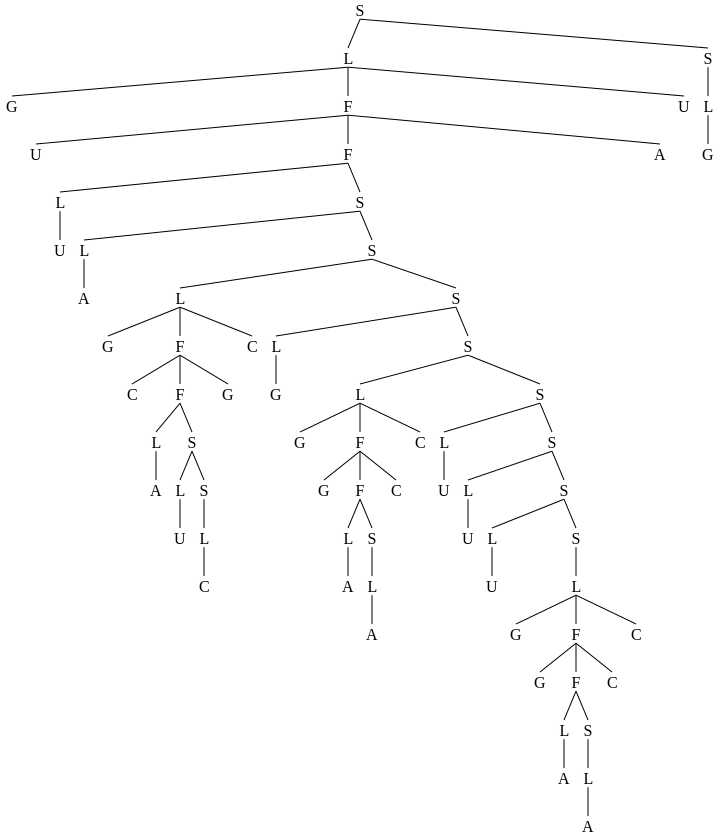

In [21]:
# Mali primer u gramatici KH-99
display(KH99(primer))

### 2.3 Obuka gramatike [⮭]<a id="par:obkh"></a>

[⮭]: #par:stoh

Kada je ceo skup za obuku predstavljen u vidu stabala izvođenja, moguće je pristupiti obučavanju modela, koje podrazumeva i indukciju same gramatike. Trening se, dakle, svodi na jednostavno prebrojavanje primenjenih pravila, a primenjena pravila se neposredno dobijaju iz stabla izvođenja. Naime, moguće je obilaskom svakog stabla izvući niz primenjenih pravila izvođenja, na osnovu kojih je nadalje moguće odrediti verovatnoće izvođenja u indukovanoj gramatici.

U nastavku je implementirana klasa koja enkapsulira gramatiku *KH-99*, nakon čega je gramatika obučena, a njena pravila izvođena prikazana. Kako gramatike nemaju podesivih hiperparametara, odmah je formiran finalni model, što znači da je obučavanje sprovedeno nad objedinjenim skupom za trening i validaciju. Uvidom u obučenu gramatiku, odnosno njenih $19$ parametara, moguće je izvesti različite zaključke. Primera radi, može se primetiti da je ubedljivo najčešće uparivanje $G-C$, za koje je poznato da je termodinamički najstabilnije. Na drugom mestu je obrnuti par $C-G$, dok je dva do tri puta manje parova $A-U$ i $U-A$. Postoji i određen nezanemarljiv broj nekanonskih parova $U-G$ i $G-U$. Takođe, u petljama su primetno češće baze $A$ i $U$, dok su $G$ i $C$ uparenije.

In [22]:
# Biblioteka za rad sa PCFG
from nltk import induce_pcfg, Nonterminal

In [23]:
# Stohastička kontekstno slobodna gramatika
class PCFG:
    # Pravljenje i obučavanje gramatike
    def __init__(self, train):
        self.gramatika = self.obuči(train)
        
        # Sortiranje pravila radi lepšeg prikaza
        self.gramatika.productions().sort(
            key=lambda p: (p.lhs(), len(p.rhs()), p.prob()), reverse=True)
    
    # Prikaz gramatike u konzoli
    def _ipython_display_(self):
        print(self.gramatika)
    
    # Pravljenje i obučavanje gramatike
    def obuči(self, train):
        # Izdvajanje svih stabala izvođenja
        train = map(KH99, train)
        
        # Izdvajanje svih pravila izvođenja
        pravila = [p for t in train for p in t.productions()]
        
        # Indukcija gramatike nad pravilima
        return induce_pcfg(Nonterminal('S'), pravila)

In [24]:
# Obučena gramatika KH-99
pcfg = PCFG(train + valid)

In [25]:
# Prikaz instancirane gramatike
pcfg

Grammar with 19 productions (start state = S)
    S -> L S [0.840851]
    S -> L [0.159149]
    L -> 'G' F 'C' [0.0593285]
    L -> 'C' F 'G' [0.0193428]
    L -> 'G' F 'U' [0.01465]
    L -> 'A' F 'U' [0.01069]
    L -> 'U' F 'A' [0.0088942]
    L -> 'U' F 'G' [0.00154166]
    L -> 'U' [0.267775]
    L -> 'A' [0.255014]
    L -> 'G' [0.207307]
    L -> 'C' [0.155458]
    F -> 'G' F 'C' [0.306676]
    F -> 'C' F 'G' [0.24437]
    F -> 'U' F 'A' [0.113225]
    F -> 'A' F 'U' [0.093187]
    F -> 'G' F 'U' [0.0208209]
    F -> 'U' F 'G' [0.0202094]
    F -> L S [0.201512]


## 3. Duboka konvolucija [⮭]<a id="par:konv"></a>

[⮭]: #par:toc

Kako je već rečeno, savremeni vrhunski pristup rešavanju velikog broja problema, pa i predviđanja strukture *RNK*, zasnovan je na [veštačkim neuronskim mrežama](https://en.wikipedia.org/wiki/Artificial_neural_network) (*ANN*). Ove mreže sastoje se od povezanih jedinica koje se nazivaju neuronima (ponekad i [perceptronima](https://en.wikipedia.org/wiki/Perceptron)), budući da je ceo pristup nadahnut biološkim učenjem. Svaka veza između neurona služi za prenos signala, kao u moždanim [sinapsama](https://en.wikipedia.org/wiki/Synapse). Svaki izlazni signal pritom je realan broj i izračunava se kao mahom nelinearna funkcija ([aktivacija](https://en.wikipedia.org/wiki/Activation_function)) otežane sume ulaznih signala. Neuroni su organizovani po slojevima, a višeslojne mreže nazivaju se [dubokim](https://en.wikipedia.org/wiki/Deep_learning). Prvi sloj je po pravilu ulazni i on predstavlja atribute (tabelarni atributi ili enkodirani sirovi podaci), poslednji je izlazni i on predstavlja predviđanja (klasa i slično), a između se nalaze tzv. skriveni slojevi, koji se mogu shvatiti kao nova (naučena) reprezentacija ulaznih podataka koja je korisna za problem koji se rešava.

[Konvolutivne neuronske mreže](https://en.wikipedia.org/wiki/Convolutional_neural_network) (*CNN*) čine posebno zanimljivu grupu dubokih mreža. Zasnivaju se upravo na pomenutoj sposobnosti konstrukcije novih atributa, i to iz sirovog signala. One zapravo uče filtere ([kernele](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29)), čijom se konvolutivnom primenom detektuju određena svojstva signala. Na primeru obrade digitalnih slika, konkretno kod problema prepoznavanja objekta na slici, filteri nižih slojeva mogli bi otkrivati jednostavne linije, a viših složene oblike. Ovakve mreže su, dakle, po pravilu duboke, jer konvolucija tek tada iskazuje svoj pun potencijal. Svaki filter zapravo je neuron, specifičan po tome što deli iste parametre za sve ulaze. Uobičajeno je, inače, smenjivanje konvolutivnih i slojeva agregacije (npr. maksimum ili prosek izlaza filtera), ali nije obavezno.

### 3.1 Shema pristupa [⮭]<a id="par:shema"></a>

[⮭]: #par:konv

U nastavku je reprodukovana shema, data na slici, a koja je objavljena 2022. godine kroz rad [*RNA secondary structure prediction with convolutional neural networks*](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04540-7). Autori su predložili jednostavan, ali efektivan pristup vođen podacima, pri čemu su dobili rezultate koji nadmašuju dotadašnje objavljene. Ideja je pritom vrlo fleksibilna, budući da ne zahteva ugnežđenost interakcija, što znači da bez problema predviđa i više nivoe strukture, poput [pseudočvorova](https://en.wikipedia.org/wiki/Pseudoknot).

<img src='../slike/shema.png' width='65%'>

Implementirani pristup se sastoji iz tri povezana koraka. U prvom, *RNK* se predstavlja (nova reprezentacija) kao trodimenzioni tenzor koji enkodira mogućnost uparivanja na osnovu razmatrane sekvence. Dalje, upotrebom duboke konvolutivne mreže predviđa se dvodimenziona mapa (matrica) koja predstavlja odabrana uparivanja. Naposletku se ta mapa postprocesira kako bi se dobila konkretna i korektna sekundarna struktura, što je željeni izlaz modela.

### 3.2 Matrica strukture [⮭]<a id="par:mstr"></a>

[⮭]: #par:konv

Za početak, reprezentacija strukture svodi se na [matricu povezanosti](https://en.wikipedia.org/wiki/Adjacency_matrix), čiji je značaj naglašen još u uvodu. Matrica je [simetrična](https://en.wikipedia.org/wiki/Symmetric_matrix), suštinski [retka](https://en.wikipedia.org/wiki/Sparse_matrix) i [istinitosnog tipa](https://en.wikipedia.org/wiki/Logical_matrix), mada se čuva kao celobrojna. Analogno nizu uparivanja, ćelija $(i, j)$ jednaka je ćeliji $(j, i)$ i svedoči o postojanju veze između baze $i$ i $j$. U slučaju $i = j$, baza je neuparena. U svakom redu i koloni samo je jedna vrednost jedinica, budući da su uparivanja jedinstvena. Ovo matrici daje karakterističan izgled, sa nanizanim vrednostima na glavnoj dijagonali, koje predstavljaju neuparene baze (petlje), kao i nizovina na sporednim dijagonalama, što su susedni parovi (zavojnice). Uz implementaciju funkcije koja pravi mapu parova na osnovu prosleđene *RNK*, prikazana je i stilizovana matrica na malom primeru *tRNK*.

In [26]:
# Prikaz stilizovane tabele
def stilizuj(tabela, cmap):
    display(tabela.style.background_gradient(cmap=cmap, axis=None))

In [27]:
# Određivanje matrice strukture
def matrica_strukture(rnk, crtaj=False):
    # Dužina RNK sekvence
    n = len(rnk.uparivanje)
    
    # Inicijalizacija praznih uparivanja
    parovi = np.zeros((n, n), dtype=np.int8)
    
    # Popunjavanje svakog uparivanja
    parovi[range(n), rnk.uparivanje] = 1
    
    # Crtanje stilizovane tabele uparivanja
    if crtaj:
        stilizuj(pd.DataFrame(parovi), 'Purples')
    # Ili vraćanje izračunate matrice parova
    else:
        return np.expand_dims(parovi, 0)

In [28]:
# Matrica strukture malog primera
matrica_strukture(primer, crtaj=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3.3 Matrica sekvence [⮭]<a id="par:msek"></a>

[⮭]: #par:konv

Kako je formirana matrica strukture, tako se formira i trodimenzioni [tenzor](https://en.wikipedia.org/wiki/Tensor) kao nova reprezentacija sekvence. Radi lakšeg razumevanja pristupa, pogodno je i ovde govoriti u terminima [kvadratne matrice](https://en.wikipedia.org/wiki/Square_matrix). Ćelija $(i, j)$ shvata se kao mogućnost uparivanja baze $i$ i $j$ na osnovu poznavanja domena. Tako vrednosti od $0$ do $5$ redom predstavljaju parove $A-U$, $U-A$, $U-G$, $G-U$, $G-C$, $C-G$. Ova matrica, dakle, nije doslovno simetrična, iako suštinski jeste. Vrednost $6$ rezervisana je za neuparene baze, odnosno slučaj $i = j$, dok vrednost $7$ označava nedozvoljena uparivanja, bilo zbog prirode potencijalnog para, bilo zbog toga što su baze previše bliske. Drugi slučaj, podsećanja radi, pokriva motiv [ukosnice sa drškom](https://en.wikipedia.org/wiki/Stem-loop), za koju je u uvodu napomenuto da sadrži najmanje tri baze i da je to ograničenje neophodno ugraditi u računarske metode. U nastavku je prikazana stilizovana matrica malog primera *tRNK*. Za kraj, ostaje napomena da se umesto matrice konvolutivnoj mreži daje tenzor, koji se dobija [enkodiranjem](https://en.wikipedia.org/wiki/One-hot) navedenih vrednosti, npr. `[0 0 1 0 0 0 0 0]` umesto indeksa `2`.

In [29]:
# Kanala ima tačno osam
kanal = 8

# Mapiranje baza u cele brojeve
baze = dict(zip('AUGC', range(4)))

In [30]:
# Izračunavanje matrice sekvence
def matrica_sekvence(rnk, razmak=3, crtaj=False):
    # Dužina RNK sekvence
    n = len(rnk.sekvenca)
    
    # Celobrojno enkodirana sekvenca
    sekvenca = np.array([baze[s] for s in rnk.sekvenca])
    
    # Matrično predstavljena sekvenca
    j = np.tile(sekvenca, (n, 1))
    
    # Transponat matrične sekvence
    i = j.transpose(1, 0)
    
    # Maska za enkodiranje parova
    maska = np.max(np.stack(((np.abs(i-j)==1), +
                             np.eye(n, dtype=np.int8))), 0)
    
    # Enkodiranje parova pomoću maske
    jedan = (i*4 + j + 1) * maska
    
    # Zanemarivanje uparivanja koja su preblizu
    for i in range(1, razmak+1):
        jedan[range(n - i), range(i, n)] = 0
        jedan[range(i, n), range(n - i)] = 0
    
    # Dodavanje nove dimenzije na početak
    jedan = np.expand_dims(jedan, 0)
    
    # Inicijalizacija matrice parova
    matrica = np.zeros((17, n, n), dtype=np.int8)
    
    # Matrično predstavljanje indeksa
    idx2 = np.tile(np.arange(n), (n, 1))
    idx1 = idx2.transpose(1, 0).reshape(-1)
    idx2 = idx2.reshape(-1)
    
    # Popunjavanje matrice uparivanjima
    matrica[jedan.reshape(-1), idx1, idx2] = 1
    
    # Odbacivanje prve, nevažne dimenzije
    matrica = matrica[1:]
    
    # Prvih šest kanala su dozvoljena uparivanja,
    # što su redom A-U, U-A, U-G, G-U, G-C, C-G
    osam = matrica[[1, 4, 6, 9, 11, 14]]
    
    # Sedmi kanal dele neuparene baze, za koje se
    # može zamisliti da su uparene same sa sobom
    osam = np.concatenate((osam, np.expand_dims(np.sum(matrica[[0, 5, 10, 15]], 0), 0)), 0)
    
    # Osmi kanal dele nedozvoljena uparivanja, što
    # uključuje biološki moguća, ali previše bliska
    osam = np.concatenate((osam, 1-np.expand_dims(np.sum(osam, 0), 0)), 0)
    
    # Crtanje stilizovane tabele enkodiranja
    if crtaj:
        # Izračunavanje matrice enkodiranja
        prikaz = [[np.argmax(j) for j in i] for i in osam.transpose(1, 2, 0)]
        
        # Prikaz stilizovane tabele enkodiranja
        stilizuj(pd.DataFrame(prikaz), 'Pastel1')
    # Ili vraćanje izračunate matrice parova
    else:
        return osam

In [31]:
# Matrica strukture malog primera
matrica_sekvence(primer, crtaj=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,6,7,7,7,7,4,7,3,4,7,4,7,7,7,7,7,4,4,3,3,3,7,7,7,7,4,4,7,3,7
1,7,6,7,7,7,7,1,7,7,2,7,2,2,2,1,1,7,7,7,7,7,2,2,1,1,7,7,1,7,2
2,7,7,6,7,7,7,1,7,7,2,7,2,2,2,1,1,7,7,7,7,7,2,2,1,1,7,7,1,7,2
3,7,7,7,6,7,7,7,0,7,7,7,7,7,7,7,7,7,7,0,0,0,7,7,7,7,7,7,7,0,7
4,7,7,7,7,6,7,7,7,4,7,4,7,7,7,7,7,4,4,3,3,3,7,7,7,7,4,4,7,3,7
5,5,7,7,7,7,6,7,7,7,5,7,5,5,5,7,7,7,7,7,7,7,5,5,7,7,7,7,7,7,5
6,7,0,0,7,7,7,6,7,7,7,7,7,7,7,7,7,7,7,0,0,0,7,7,7,7,7,7,7,0,7
7,2,7,7,1,7,7,7,6,7,7,7,2,2,2,1,1,7,7,7,7,7,2,2,1,1,7,7,1,7,2
8,5,7,7,7,5,7,7,7,6,7,7,7,5,5,7,7,7,7,7,7,7,5,5,7,7,7,7,7,7,5
9,7,3,3,7,7,4,7,7,7,6,7,7,7,7,7,7,4,4,3,3,3,7,7,7,7,4,4,7,3,7


### 3.4 Priprema paketa [⮭]<a id="par:paket"></a>

[⮭]: #par:konv

Umesto niza sirovih vrednosti, neuronska mreža na ulazu očekuje koliko-toliko strukturirane [pakete](https://en.wikipedia.org/wiki/Online_machine_learning) (*batch*), što između ostalog doprinosi efikasnosti učenja. U konkretnom slučaju, paket se jednostavno priprema tako što se na osnovu svake *RNK* iz uzorka formira odgovarajuća matrica sekvence i strukture.

In [32]:
# Priprema uzorka za prosleđivanje mreži
def upakuj(uzorak):
    # Određivanje matrice svake sekvence
    x = [matrica_sekvence(rnk) for rnk in uzorak]
    
    # Određivanje matrice svake strukture
    y = [matrica_strukture(rnk) for rnk in uzorak]
    
    # Vraćanje naslaganih vrednosti
    return np.stack(x), np.stack(y)

In [33]:
# Pravljenje paketa sa malim primerom
paket = upakuj([primer])

# Dimenzije ulaza paketa sa malim primerom
print(paket[0].shape, '→ ulaz')

# Dimenzije izlaza paketa sa malim primerom
print(paket[1].shape, '→ izlaz')

(1, 8, 30, 30) → ulaz
(1, 1, 30, 30) → izlaz


Kako bi paketna obrada imala smisla, svaka sekvenca iz uzorka mora biti iste dužine. Neophodno je i ograničiti veličinu paketa, koja mora biti dovoljno velika da pospeši obuku, ali dovoljno mala da ne preoptereti procesor. Autori predlažu do $17$ slogova u jednom paketu. Tako za obuku ima $333$ paketa, za proveru $68$, a za validaciju $64$. Četiri su koraka u procesu uzorkovanja: [mešanje](https://en.wikipedia.org/wiki/Shuffling) ulaza, [stabilno sortiranje](https://en.wikipedia.org/wiki/Sorting_algorithm#Stability) po dužini, [grupisanje](https://en.wikipedia.org/wiki/Aggregate_function) suseda po dužini, mešanje izlaza.

In [34]:
# Biblioteka za mešanje niza
from random import shuffle

# Biblioteka za jednaku podelu
from more_itertools import chunked_even

In [35]:
# Predložena veličina paketa
paket = 17

In [36]:
# Uzorkovanje sekvenci iste dužine
def uzorkuj(podaci, paket=paket):
    # Inicijalno mešanje niza podataka
    shuffle(podaci)
    
    # Funkcija koja određuje dužinu
    dužina = lambda rnk: len(rnk.sekvenca)
    
    # Stabilno sortiranje prema dužini
    podaci = sorted(podaci, key=dužina)
    
    # Spisak pripremljenih grupa
    uzorci = []
    
    # Grupisanje sekvenci prema dužini
    for _, rnk in groupby(podaci, dužina):
        # Parčanje grupe na male pakete
        uzorci += chunked_even(rnk, paket)
    
    # Mešanje pripremljenih grupa
    shuffle(uzorci)
    
    # Vraćanje promešanih grupa
    return uzorci

In [37]:
# Izveštavanje o ukupom broju paketa
print(len(uzorkuj(train)), '→ paketa za obuku')
print(len(uzorkuj(test)), '→ paketa za proveru')
print(len(uzorkuj(valid)), '→ paketa za validaciju')
print(len(uzorkuj(train + valid)), '→ finalnih paketa')

333 → paketa za obuku
68 → paketa za proveru
64 → paketa za validaciju
382 → finalnih paketa


Na kraju je implementirana funkcija koja objedinjuje ova dva koraka, tako da se mogu zajedno brže primeniti, samo jednim spoljnim pozivom.

In [38]:
# Priprema paketa za prosleđivanje mreži
def pripremi(podaci):
    yield from map(upakuj, uzorkuj(podaci))

### 3.5 Odabir arhitekture [⮭]<a id="par:cnn"></a>

[⮭]: #par:konv

Kako su sada mrežni ulaz i izlaz dobro definisani kao paketi trodimenzionih tenzora sekvenci i dvodimenzionih mapa struktura, moguće je pristupiti odabiru arhitekture same mreže, čiji će cilj biti da prvu reprezentaciju uspešno svede na drugu. Ideja je, dakle, da mreža od svih ponuđenih uparivanja odabere samo neka, konkretno po jedno za svaku nukleobazu. Citirani rad predlaže jednostavnu, ali duboku konvolutivnu arhitekturu po shemi prikazanoj na slici.

<img src='../slike/cnn.png' width='75%'>

Predloženu arhitekturu karakterišu tri dela. Na početku se nalazi dupli konvolutivni blok, nakon čega sledi $M$ rezidualnih blokova, a zatim još $N$ posebnih rezidualnih blokova. Svaki od $M$ i $N$ blokova zapravo je dupli konvolutivni blok sa [preskocima](https://en.wikipedia.org/wiki/Residual_neural_network), kako je i prikazano na slici. Pritom je jedan konvolutivni blok zapravo [filter](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29) (*kernel*) dimenzije tri, praćen [unutrašnjom standardizacijom](https://en.wikipedia.org/wiki/Batch_normalization) (*batch normalization*) i propuštajućom [ispravljačkom funkcijom](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) (*leaky ReLU*) kao aktivacijom. Kako bi glavne dimenzije rezultata ostale iste, podrazumevano se koristi popuna (*padding*). Očekivano, $M$ blokovi su nezavisni i svaki uči svoje parametre. Sledećih $N$ blokova, međutim, posebno je po tome što deli parametre. To je faktički samo jedan blok koji se ponavlja $N$ puta, sa samim sobom kao svojim ulazom, po ugledu na [rekurentne neuronske mreže](https://en.wikipedia.org/wiki/Recurrent_neural_network) (*RNN*). U njemu se nalazi i čitanje rezultata (*readout*), koje se sastoji od konvolutivnog bloka dimenzije jedan i običnog konvolutivnog sloja iste dimenzije. Početni blokovi imaju po $32$ izlazna [kanala](https://en.wikipedia.org/wiki/Channel_%28digital_image%29), poslednji dva, dok krajnji obični konvolutivni sloj ima samo jedan, što odgovara matrici strukture. Samo krajnji konvolutivni sloj ima vektor slobodnih članova (*bias*). Budući da filteri nisu potpuno povezani i pritom dele parametre za sve ulaze, konvolutivne mreže su same po sebi [regularizovane](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29). U nastavku je ova shema implementirana pomoću modula [*PyTorch*](https://pytorch.org/).

In [39]:
# Biblioteka za klasični rad sa mrežama
import torch.nn as nn

In [40]:
# Dupli konvolutivni blok kao modul
class Blok(nn.Module):
    # Konstrukcija konvolutivnog bloka
    def __init__(self, ulaz, izlaz, preskok,
                 kernel=3, padding='same', bias=False):
        # Inicijalizacija PyTorch modula
        super(Blok, self).__init__()
        
        # Čuvanje podatka o preskoku
        self.preskok = preskok
        
        # Svaki blok je sekvencijalan
        self.blok = nn.Sequential(
            # Prvo se primenjuje konvolucija
            nn.Conv2d(ulaz, izlaz, kernel, padding=padding, bias=bias),
            # Zatim unutrašnja standardizacija
            nn.BatchNorm2d(izlaz),
            # Zatim propuštajući ispravljač
            nn.LeakyReLU(),
            # Pa još jedna konvolucija
            nn.Conv2d(izlaz, izlaz, kernel, padding=padding, bias=bias),
            # Pa opet unutrašnja standardizacija
            nn.BatchNorm2d(izlaz)
            # Drugi ispravljač je u prolazu
        )
        
        # Propuštajući ispravljač
        self.lrelu = nn.LeakyReLU()
    
    # Prolaz kroz konvolutivni blok
    def forward(self, x):
        # Primena konstruisanog bloka
        y = self.blok(x)
        
        # Propuštajući ispravljač sa preskokom
        if self.preskok:
            return self.lrelu(x + y)
        # Propuštajući ispravljač bez preskoka
        else:
            return self.lrelu(y)

Navedenu arhitekturu i [hiperparametre](https://en.wikipedia.org/wiki/Hyperparameter_%28machine_learning%29) autori su odabrali eksperimentalno, ali je svaku odluku moguće i teorijski opravdati. Primera radi, ispravljačka funkcija se na mnogim poljima pokazala kao veoma uspešna aktivacija, pri čemu propuštajuća verzija rešava neke probleme koje ima obična *ReLU*. Upotreba unutrašnje standardizacije takođe je vrlo zastupljena i korisna, budući da ubrzava i pospešuje obučavanje, a takođe deluje i regularizaciono, kao da je u ulaz unet određeni šum. Preskoci daju sličaj efekat ubrzanja. Predlaže se i sukcesivno računanje greške nakon svakog od $N$ blokova, pa je i ono implementirano. Na taj način se konceptualno udvostručuje veličina paketa, što dodatno ubrzava obuku. Obraćena je pažnja i na sledeće implementacione detalje: biološki nedozvoljena uparivanja se posebno obeshrabruju prilikom prolaza kroz mrežu ([maska](https://en.wikipedia.org/wiki/Mask_%28computing%29) sa kaznom, što je takođe vid regularizacije), insistira se na simetričnosti rezultujuće mape (prosek izlaza i njegovog [transponata](https://en.wikipedia.org/wiki/Transpose)), insistira se na verovatnosnom tumačenju mape ([meki maksimum](https://en.wikipedia.org/wiki/Softmax_function), *softmax*).

In [41]:
# Biblioteka za rad sa tenzorima
import torch

In [42]:
# Duboka konvolutivna mreža kao modul
class CNN(nn.Module):
    # Konstrukcija konvolutivne mreže
    def __init__(self, M, N, ulaz=8, izlaz=32):
        # Inicijalizacija PyTorch modula
        super(CNN, self).__init__()
        
        # Pamćenje veličina blokova
        self.M, self.N = M, N
        
        # Mreža započinje blokom bez preskoka
        self.cnn = nn.Sequential(Blok(ulaz, izlaz, preskok=False))
        
        # Zatim se niže M blokova sa preskokom
        for _ in range(self.M):
            self.cnn.append(Blok(izlaz, izlaz, preskok=True))
        
        # Sledeći je deljeni blok sa N prolaza
        self.deljeni = Blok(izlaz, izlaz, preskok=True)
        
        # Hiperparametri bloka za čitanje
        kernel, _2d, _1d, bias = 1, 2, 1, False
        
        # Na kraju se instancira blok za čitanje
        self.čitanje = nn.Sequential(
            # Prvo se konvolucijom svodi na dva kanala
            nn.Conv2d(izlaz, _2d, kernel, bias=bias),
            # Zatim ide unutrašnja standardizacija
            nn.BatchNorm2d(_2d),
            # Zatim propuštajući ispravljač
            nn.LeakyReLU(),
            # Poslednja konvolucija daje jedan kanal
            nn.Conv2d(_2d, _1d, kernel, bias=not bias)
        )
        
        # Meki maksimum
        self.softmax = nn.Softmax(-1)
    
    # Prolaz kroz konvolutivnu mrežu
    def forward(self, x):
        # Niz izlaza nakon svakog od N prolaza
        izlazi = []
        
        # Maska sa velikom kaznom ako je odabran
        # poslednji kanal sa nedozvoljenim parovima
        maska = -1000 * x[:, -1].clone().unsqueeze(1)
        
        # Primena sekvencijalnog dela
        y = self.cnn(x)
        
        # Ponavljanje bloka sa N prolaza
        for _ in range(self.N):
            # Vrednost deljenog bloka
            y = self.deljeni(y)
            
            # Čitanje tekućeg rezultata
            _y = self.čitanje(y)
            
            # Kažnjavanje nedozvoljenih parova
            _y = _y + maska
            
            # Uprosečavanje rezultata i njegovog
            # transponata kako bi bio simetričan
            _y = (_y + _y.transpose(-1, -2)) / 2
            
            # Meki maksimum radi interpretacije
            _y = self.softmax(_y)
            
            # Čuvanje dorađenog rezultata
            izlazi.append(_y)
        
        # Spojen rezultat svakog od N prolaza
        return torch.cat(izlazi)

### 3.6 Sumarizacija [⮭]<a id="par:suma"></a>

[⮭]: #par:konv

Za obradu kraćih sekvenci, preporuka autora je da se uzmu vrednosti $M = N = 2$, pa su upravo one i odabrane. Prikazana je sumarizacija takvog modela u pesimističnom slučaju u kontekstu odabranih *tRNK*: najveći paket od $17$ slogova sa sekvencama najveće dužine $95$. Parametara koji se uče ima $67.399$, a zauzeće memorije pri prolasku kroz mrežu je $\sim 640$ [MB](https://en.wikipedia.org/wiki/Megabyte). Broj matričnih operacija (množenja i sabiranja, *mult-adds*) nešto je veći, ali ipak ništa preterano.

In [43]:
# Biblioteka za sumarizaciju modela
from torchinfo import summary

In [44]:
# Instanciranje neobučenog modela
cnn = CNN(M=2, N=2)

In [45]:
# Maksimalna dužina sekvence u skupu za obuku
dužina = max(len(rnk.sekvenca) for rnk in train)

# Sumarizacija modela u pesimističnom slučaju
display(summary(cnn, col_names=('kernel_size', 'input_size', 'output_size', 'num_params',
                'mult_adds'), col_width=17, input_size=(paket, kanal, dužina, dužina)))

Layer (type:depth-idx)                   Kernel Shape      Input Shape       Output Shape      Param #           Mult-Adds
CNN                                      --                [17, 8, 95, 95]   [34, 1, 95, 95]   --                --
├─Sequential: 1-1                        --                [17, 8, 95, 95]   [17, 32, 95, 95]  --                --
│    └─Blok: 2-1                         --                [17, 8, 95, 95]   [17, 32, 95, 95]  --                --
│    │    └─Sequential: 3-1              --                [17, 8, 95, 95]   [17, 32, 95, 95]  11,648            1,767,458,176
│    │    └─LeakyReLU: 3-2               --                [17, 32, 95, 95]  [17, 32, 95, 95]  --                --
│    └─Blok: 2-2                         --                [17, 32, 95, 95]  [17, 32, 95, 95]  --                --
│    │    └─Sequential: 3-3              --                [17, 32, 95, 95]  [17, 32, 95, 95]  18,560            2,827,931,776
│    │    └─LeakyReLU: 3-4               --

Alternativna sumarizacija modela ne uzima u obzir prolaz kroz mrežu, pa ne poznaje parametre, ali zato precizno prikazuje sve odabrane hiperparametre.

In [46]:
# Alternativna sumarizacija modela
display(cnn)

CNN(
  (cnn): Sequential(
    (0): Blok(
      (blok): Sequential(
        (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (lrelu): LeakyReLU(negative_slope=0.01)
    )
    (1): Blok(
      (blok): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (lr

### 3.7 Obuka filtera [⮭]<a id="par:obcnn"></a>

[⮭]: #par:konv

Upotreba obučene mreže je jednostavna: podaci se propuste kroz neurone (filtere) i pročita se izlaz, koji se zbog primenjenog mekog maksimuma tumači kao verovatnoća, tj. sigurnost mreže u postojanje konkretnog uparivanja. Obučavanje je, s druge strane, znatno složeniji proces. Mada je i dalje reč o [proceni maksimalne verovatnoće](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), kao kod stohastičkih gramatika, kod neuronski mreža ova maksimizacija ipak nije neposredna. Umesto toga, minimizuje se pogodna [funkcija greške](https://en.wikipedia.org/wiki/Loss_function), čiji izbor zavisi od prirode problema. Ova funkcija pritom nije [konveksna](https://en.wikipedia.org/wiki/Convex_optimization), s obzirom na složenost transformacije između ulaznog i izlaznog sloja, budući da je predviđanje zapravo kompozicija nelinearnih funkcija. Neophodno je optimizovati veliki broj težina (parametara) u svakom sloju, što zahteva dodatnu pažnju. Poznato rešenje je [propagacija unazad](https://en.wikipedia.org/wiki/Backpropagation) (*backpropagation*), koja sukcesivno računa [gradijente](https://en.wikipedia.org/wiki/Gradient) na svakom sloju koristeću [pravilo lanca](https://en.wikipedia.org/wiki/Chain_rule).

Po preporukama autora citiranog rada, korišćen je optimizator [*Adam*](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam), koji je varijanta stohastičkog gradijentnog spusta, možda najpoznatije tehnike optimizacije. Ovaj metod ocenjuje prvi i drugi momenat gradijenata i kombinuje ih na način koji ubrzava konvergenciju. [Stopa učenja](https://en.wikipedia.org/wiki/Learning_rate) je $5 \cdot 10^{-3}$. Odabrana greška koja se minimizuje je jednostavno [srednjekvadratno odstupanje](https://en.wikipedia.org/wiki/Mean_squared_error) (*MSE*) predviđenih vrednosti od tačnih. Treniranje je kratko i traje samo pet epoha, pri čemu se tekući parametri čuvaju na kraju svake, kako bi se posle uporedili. Pored samog obučavanja, implementirano je i nekoliko pomoćnih funkcija.

In [47]:
# Biblioteka za fajl sistem
import os, os.path

# Biblioteka za praćenje iteracija
from tqdm import tqdm

# Biblioteka za minimizaciju greške
from torch.optim import Adam

In [48]:
# Odabrani broj epoha
epoha = 5

# Odabrana stopa učenja
stopa = 5e-3

In [49]:
# Prevođenje numpy niza u torch tenzor
def tenzor_od_niza(niz):
    return torch.from_numpy(niz.astype(np.float32))

In [50]:
# Učitavanje modela sa diska
def učitaj_model(cnn, putanja):
    cnn.load_state_dict(torch.load(putanja))

In [51]:
# Čuvanje modela na disk
def sačuvaj_model(cnn, putanja):
    torch.save(cnn.state_dict(), putanja)

In [52]:
# Formatiranje imena modela na disku
def formatiraj(folder, ime, t, i):
    return f'{folder}{ime}_{t}_{i}.pt'

In [53]:
# Pravljenje potrebnih direktorijuma
def napravi_folder(datoteka):
    os.makedirs(os.path.dirname(datoteka), exist_ok=True)

In [54]:
# Korak predviđanja paketa
def cnn_korak(cnn, x, y=None):
    # Ulazni tenzor paketa;
    # dimenzije [B, 8, N, N]
    x = tenzor_od_niza(x)

    # Predviđanje uz dupliranje;
    # dimenzije [2B, 1, N, N]
    y_pred = cnn(x)
    
    # Kraj ukoliko nema dalje
    if y is None:
        return y_pred
    
    # Izlazni tenzor paketa;
    # dimenzije [B, 1, N, N]
    y = tenzor_od_niza(y)

    # Ponavljanje izlaznog tenzora zbog
    # dupliranja; dimenzije [2B, 1, N, N]
    ponovci = y_pred.size(0) // y.size(0)
    y = y.repeat(ponovci, 1, 1, 1)
    
    # Vraćanje sređenih podataka
    return x, y, y_pred

# Dodavanje nove funkcije klasi
CNN.korak = cnn_korak

In [55]:
# Obučavanje konvolutivne neuronske mreže
def cnn_obuči(cnn, train, t, folder='../model/',
              stopa=stopa, epoha=epoha):
    # Pravljenje optimizatora nad mrežom
    if not hasattr(cnn, 'adam'):
        cnn.adam = Adam(cnn.parameters(), stopa)
    
    # Odabrana srednjekvadratna greška
    if not hasattr(cnn, 'mse'):
        cnn.mse = nn.MSELoss()
    
    # Direktorijum za modele
    cnn.folder = folder
    
    # Pravljenje direktorija za modele
    napravi_folder(cnn.folder)
    
    # Ime modela (klase) malim slovima
    cnn.ime = cnn.__class__.__name__.lower()
    
    # Određivanje poslednje epohe
    for i in range(epoha, -1, -1):
        # Formatirano ime modela na disku
        formatirano = formatiraj(cnn.folder, cnn.ime, t, i)
        
        # Učitavanje modela ako postoji
        if os.path.exists(formatirano):
            učitaj_model(cnn, formatirano)
            
            # Izlazak iz petlje
            break
    
    # Iteracija kroz epohe
    for i in range(i, epoha):
        # Prolazak kroz trening pakete
        for x, y in tqdm(pripremi(train)):
            # Čišćenje gradijenata
            cnn.adam.zero_grad()
            
            # Predviđanje na paketu
            x, y, y_pred = cnn.korak(x, y)
            
            # Izračunavanje greške na paketu
            greška = cnn.mse(y_pred, y)
            
            # Propagacija greške unazad
            greška.backward()
            
            # Korak optimizatora
            cnn.adam.step()
        
        # Čuvanje modela na kraju epohe
        sačuvaj_model(cnn, formatiraj(cnn.folder, cnn.ime, t, i+1))

# Dodavanje nove funkcije klasi
CNN.obuči = cnn_obuči

In [56]:
# Obučena konvolutivna mreža
cnn.obuči(train, 'train')

### 3.8 Validacija obuke [⮭]<a id="par:val"></a>

[⮭]: #par:konv

Kako je napomenuto još u uvodu, razmatrana baza *RNAStralign* promišljeno je [podeljena](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) na skupove za obučavanje (trening), proveru (test) i validaciju u približnom odnosu $80\%−10\%−10\%$. Model se ukalupljuje u prvi skup, drugi služi za evaluaciju, pa ostaje treći. On zapravo služi da podešavanje hiperparametara, pri čemu se biraju oni koji daju najbolji odnos uspeha na skupovima za trening i validaciju. Model, dakle, neposredno vidi trening skup (kroz učenje parametara), posredno validacioni (kroz podešavanje hiperparametara), dok test skup uopšte ne vidi u toku obuke, već tek na samom kraju, prilikom evaluacije. Kako su već odabrani optimalni hiperparametri iz literature, validacioni skup ovde je poslužio za srodan zadatak, a to je praćenje optimizacije. Značajno je utvrditi da li greška stabilno opada kroz epohe, kako na podacima u koje se model ukalupljuje, tako i na neviđenima. Ovde to jeste slučaj.

In [57]:
# Biblioteka za JSON format
import json

# Biblioteka za vizuelizacije
from matplotlib.ticker import MaxNLocator

In [58]:
# Sigurno otvaranje datoteke
def fopen(datoteka):
    # Pravljenje potrebnih direktorijuma
    napravi_folder(datoteka)
    
    # Otvaranje datoteke za pisanje
    return open(datoteka, 'w')

In [59]:
# Prosečna greška pri validaciji
def cnn_greška(cnn, valid):
    # Zanemarivanje gradijenata
    with torch.no_grad():
        # Niz grešaka po paketima
        greške = []

        # Prolazak kroz validacione pakete
        for x, y in tqdm(pripremi(valid)):
            # Veličina paketa
            paket = x.shape[0]
            
            # Predviđanje na paketu
            x, y, y_pred = cnn.korak(x, y)
            
            # Uklanjanje dupliranih vrednosti
            y, y_pred = y[-paket:], y_pred[-paket:]
            
            # Prosečna greška tekućeg paketa
            greška = cnn.mse(y_pred, y)
            
            # Ukupna greška tekućeg paketa
            greške.append(paket * greška.item())
    
        # Vraćanje prosečne greške
        return np.mean(greške)

# Dodavanje nove funkcije klasi
CNN.greška = cnn_greška

In [60]:
# Validacija sprovedene obuke
def cnn_valid(cnn, train, valid, epoha=epoha):
    # Raspon epoha
    raspon = range(1, epoha+1)
    
    # Srednja greške na skupu za obuku
    greške_train = []
    
    # Srednja greške pri validaciji
    greške_valid = []
    
    # Iteracija kroz epohe
    for i in raspon:
        # Putanja JSON predikcije
        putanja = f'../valid/{cnn.ime}_{i}.json'
        
        try:
            # Pokušaj čitanja grešaka sa lokala
            with open(putanja) as f:
                greška_train, greška_valid = json.load(f)
        except:
            # Formatirano ime modela na disku
            formatirano = formatiraj(cnn.folder, cnn.ime, 'train', i)
            
            # Učitavanje parametara epohe
            učitaj_model(cnn, formatirano)
            
            # Srednja greška na skupu za obuku
            greška_train = cnn.greška(train)

            # Srednja greška pri validaciji
            greška_valid = cnn.greška(valid)
            
            # Upisivanje na lokal za ubuduće
            with fopen(putanja) as f:
                json.dump([greška_train, greška_valid], f)
        
        # Dodavanje novih grešaka
        greške_train.append(greška_train)
        greške_valid.append(greška_valid)
    
    # Celobrojna osa sa brojem epohe
    plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Ucrtavanje prosečnih grešaka po epohama
    plt.plot(raspon, greške_train, label='train')
    plt.plot(raspon, greške_valid, label='valid')
    
    # Oznake osa za radni broj epohe i grešku
    plt.xlabel('Redni broj epohe')
    plt.ylabel('Srednjekvadratna greška')
    
    # Ucrtavanje legende
    plt.legend()

# Dodavanje nove funkcije klasi
CNN.validiraj = cnn_valid

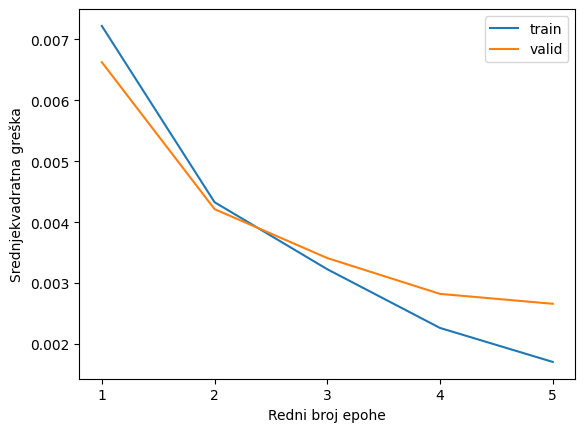

In [61]:
# Validacija sprovedene obuke
cnn.validiraj(train, valid)

Oprobane su i različite dodatne tehnike regularizacije. Regularizacija [izostavljanjem](https://en.wikipedia.org/wiki/Dilution_%28neural_networks%29) podrazumeva slučajno zanemarivanje pojedinih neurona prilikom obučavanja, što zapravo znači anuliranje njihovih težina u jednom konkretnom koraku obuke. Na taj način sprečava se da se neki filteri previše specijalizuju, odnosno zapamte previše specifične pojedinosti iz skupa za obuku. Mreža time postaje robusnija, a obučavanje podseća na istovremenu obuku ansambla. Ova tehnika, međutim, znatno usporava obuku na skupu kratkih sekvenci, pri čemu ne daje bolje rezultate, pa u nastavku nije prikazana. Testirana je i [$\ell_2$](https://en.wikipedia.org/wiki/Euclidean_space#Euclidean_norm) regularizacija, koja insistira na malim težinama. Ona brzo konvergira i daje model visoke preciznosti, ali veoma niskog odziva, pa ni ona nije prikazana. Kako je zaključak da je prethodno opisani model sasvim zadovoljavajući, može se formirati finalni model dodavanjem validacionog skupa podacima za obučavanje.

In [62]:
# Instanciranje neobučenog modela
cnn = CNN(M=2, N=2)

# Obučavanje finalnog modela mreže
cnn.obuči(train + valid, 'final')

## 4. Evaluacija modela [⮭]<a id="par:eval"></a>

[⮭]: #par:toc

Svi modeli se ukalupljuju u obeleženi skup za obučavanje. Parametri modela podešavaju se tako da predviđanja u fazi predikcije budu što sličnija prosleđenim obeležjima, odnosno da [greška](https://en.wikipedia.org/wiki/Loss_function) bude što manja. Naravno, ne očekuje se da se model savršeno prilagodi trening skupu. To je, štaviše, češto problematično, jer se usput gubi na generalizaciji, te dolazi do problema [preprilagođavanja](https://en.wikipedia.org/wiki/Overfitting). S druge strane, može doći i do potprilagođavanja, kada model ne uspeva da uhvati pravilnosti u podacima. Poželjno je u fazi provere oceniti moć modela, kao i uporediti različite pristupe, što su ovde gramatika *KH-99* i konvolutivna mreža. Prethodno je, međutim, neophodno primeniti obučene modele (korak predikcije) i svesti njihov izlaz na konkretnu i korektnu sekundarnu strukturu *RNK*.

### 4.1 Najbolje stablo [⮭]<a id="par:maks"></a>

[⮭]: #par:eval

Može se primetiti da probabilističke kontekstno slobodne gramatike, primenjene na problem predviđanja sekundarne strukture *RNK*, zapravo uče [zajedničku raspodelu](https://en.wikipedia.org/wiki/Joint_probability_distribution) sekvence i strukture u vidu stabla izvođenja. One su, dakle, [generativni model](https://en.wikipedia.org/wiki/Generative_model), pa mogu poslužiti i za generisanje slučajnih instanci, što se svodi na uzorkovanje iz pretpostavljene raspodele na osnovu naučenih verovatnosnih parametara. U fazi obuke, kako je već pomenuto, stablo izvođenja je jedinstveno za poznatu sekvencu i strukturu. U fazi provere, međutim, poznata je samo sekvenca, a broj mogućih struktura je veliki. Cilj predviđanja je odrediti najbolju.

Najbolja struktura, očekivano, dobija se obilaskom najboljeg stabla, a najboljim stablom smatra se ono koje je najverovatnije prema obučenom modelu za datu sekvencu. Drugim rečima, predviđanje se svodi na određivanje najverovatnijeg stabla izvođenja, odnosno maksimizaciju verovatnoće drveta. Biblioteka *NLTK* za te potrebe koristi [Viterbijev](https://en.wikipedia.org/wiki/Viterbi_algorithm) parser, koji implementira verziju algoritma [*CYK*](https://en.wikipedia.org/wiki/CYK_algorithm) specijalizovanu za stohastičke gramatike. Ovaj algoritam zasnovan je na [analizi naviše](https://en.wikipedia.org/wiki/Bottom-up_parsing) (*bottom-up*), što znači da prvo parsira manje podjedinice, nakon čega ih sklapa u veće celine, pri čemu se sasvim oslanja na dinamičko programiranje.

Prvo je implementirana pomoćna funkcija koja pravi strukturu u obliku ilustrativne niske u formatu tačke i zagrada na osnovu prosleđenog drveta parsiranja.

In [63]:
# Pravljenje strukture na osnovu drveta
def niska_od_drveta(*drvo):
    # Ukoliko je list, neuparena je baza
    if isinstance(drvo[0], str):
        if len(drvo) == 1:
            return '.'

        # Tročlano izvođenje je uparivanje
        if len(drvo) == 3:
            return '(' + niska_od_drveta(*drvo[1]) + ')'

    # Sva ostala izvođenja se razlažu
    return ''.join(niska_od_drveta(*d) for d in drvo)

In [64]:
# Primer pravljenja niske od drveta
print(niska_od_drveta(['G', ['A', 'U'], 'C']))

(..)


Zatim je realizovana funkcija predviđanja pomoću pomenutog Viterbijevog parsera iz biblioteke *NLTK*. Sam parser vraća stablo, koje se prevodi u nisku.

In [65]:
# Biblioteka za rad sa PCFG
from nltk import ViterbiParser

In [66]:
# Predviđanje strukture kao stabla
def parsiraj(pcfg, test):
    # Pravljenje parsera nad gramatikom
    if not hasattr(pcfg, 'parser'):
        pcfg.parser = ViterbiParser(pcfg.gramatika)

    # Izdvajanje sekvence testne RNK
    sekvenca = test.sekvenca

    # Formiranje stabla izvođenja
    return pcfg.parser.parse_one(sekvenca)

# Dodavanje nove funkcije klasi
PCFG.stablo = parsiraj

In [67]:
# Predviđanje strukture kao niske
def pcfg_niska(pcfg, test):
    return niska_od_drveta(*parsiraj(pcfg, test))

# Dodavanje nove funkcije klasi
PCFG.niska = pcfg_niska

U nastavku je prikazan rad obučene gramatike na malom primeru *tRNK*. Data je predviđena struktura, a zatim i odgovarajuće najverovatnije stablo izvođenja. Primetno je da su unutrašnje zavojnice dobrim delom pogođene, dok je spoljašnja zanemarena, odnosno proglašena za spoljašnji nestrukturirani lanac.

In [68]:
# Sekvenca malog primera
print(primer.sekvenca, '→ sekvenca')

# Stvarna struktura malog primera
print(primer.struktura, '→ struktura')

# Predikcija strukture malog primera
predikcija = pcfg.niska(primer)

# Predviđena struktura malog primera
print(predikcija, '→ PCFG model')

GUUAGCAUCGCGGGAACCUUUGGAACCAUG → sekvenca
((..((...)).((..))...((..)))). → struktura
....((...))(((..)))..((..))... → PCFG model


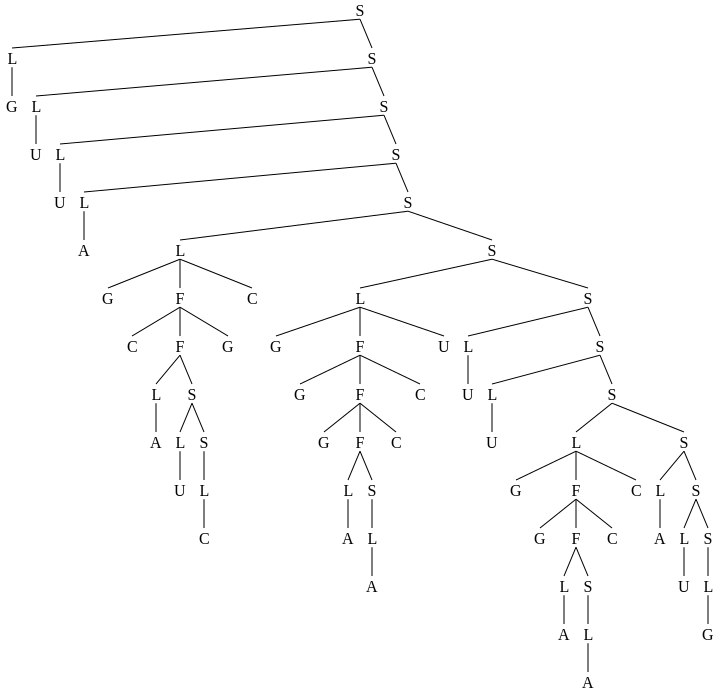

In [69]:
# Najverovatnije stablo izvođenja malog primera
display(pcfg.stablo(primer))

Iako ilustrativna, niska nije uvek dobra reprezentacija sekundarne strukture. Zato je implementirana funkcija koja nisku prevodi u niz uparivanja.

In [70]:
# Niz uparivanja od niske strukture
def niz_od_niske(struktura):
    # Inicijalizacija uparivanja
    uparivanje = [*range(len(struktura))]

    # Inicijalizacija steka indeksa
    stek = []

    # Prolazak kroz celu strukturu
    for i, c in enumerate(struktura):
        # Stavljanje prvog člana uparivanja na stek
        if c == '(':          
            stek.append(i)

        # Dohvatanje prvog člana uparivanja
        elif c == ')':
            j = stek.pop()

            # Uparivanje prvog i drugog člana
            uparivanje[i] = j
            uparivanje[j] = i
        # Neuparena baza se uparuje sama sa sobom
        else:
            uparivanje[i] = i

    # Vraćanje izračunatog uparivanja
    return uparivanje

In [71]:
# Stvarni niz uparivanja malog primera
print(primer.uparivanje, '→ uparivanje')

# Primer niza uparivanja od niske strukture
print(niz_od_niske(predikcija), '→ PCFG model')

[28, 27, 2, 3, 10, 9, 6, 7, 8, 5, 4, 11, 17, 16, 14, 15, 13, 12, 18, 19, 20, 26, 25, 23, 24, 22, 21, 1, 0, 29] → uparivanje
[0, 1, 2, 3, 10, 9, 6, 7, 8, 5, 4, 18, 17, 16, 14, 15, 13, 12, 11, 19, 20, 26, 25, 23, 24, 22, 21, 27, 28, 29] → PCFG model


Spajanjem prethodno definisanih funkcija može se dobiti nova, koja nakon stabla izvođenja i formatirane niske formira niz uparivanja kao predviđanje.

In [72]:
# Predviđanje strukture kao niza
def pcfg_niz(pcfg, test):
    return niz_od_niske(niska_od_drveta(*parsiraj(pcfg, test)))

# Dodavanje nove funkcije klasi
PCFG.niz = pcfg_niz

In [73]:
# Niz uparivanja na malom primeru
print(pcfg.niz(primer))

[0, 1, 2, 3, 10, 9, 6, 7, 8, 5, 4, 18, 17, 16, 14, 15, 13, 12, 11, 19, 20, 26, 25, 23, 24, 22, 21, 27, 28, 29]


### 4.2 Najbolje uparivanje [⮭]<a id="par:maku"></a>

[⮭]: #par:eval

Za razliku od *PCFG*, kod neuronskih mreža je korak predviđanja neizostavni deo obučavanja, budući da se parametri podešavaju na osnovu grešaka. Ipak, prethodno definisana mreža ne predviđa neposredno strukturu, već matricu povezanosti. Stoga je neophodno svesti matricu na konkretnu strukturu. Osim toga, predviđena matrica, očekivano, nije savršena i ne ispunjava uslov da u svakom redu i koloni ima tačno jednu jedinicu. Njene vrednosti su realne, tako da svaka ćelija $(i, j)$ svedoči o sigurnosti modela (verovatnoći) da je baza $i$ povezana sa bazom $j$. Pritom par najveće verovatnoće nije nužno simetričan. Sve ovo znači da bi se jednostavnim uzimanjem uparivanja najveće verovatnoće za svaku pojedinačnu nukleobazu (svaki red matrice povezanosti) moglo dobiti npr. da se baza $i$ uparuje sa bazom $j$, a baza $j$ sa bazom $k$, pri čemu $i \neq k$. Ovo, naravno, ne bi bila biološki korektna struktura, pa se ta ideja odbacuje.

<img src='../slike/blossom.png' width='65%'>

Autori citiranog rada kao rešenje predlažu posmatranje rezultujuće matrice upravo kao matrice povezanosti odgovarajućeg grafa sekundarne strukture, što je pristup koji je pomenut u uvodu ovog rada. Ideja je pronaći [uparivanje maksimalne težine](https://en.wikipedia.org/wiki/Maximum_weight_matching), što je skup grana (uparivanja) najveće ukupne težine takav da je svaki čvor (nukleobaza) povezan (uparen) samo sa jednim drugim čvorom (bazom). Težina grane pritom je realna vrednost iz predviđene matrice. Klasičan algoritam [*blossom*](https://en.wikipedia.org/wiki/Blossom_algorithm), međutim, ne uzima u obzir petlje (neuparene baze), pa se taj problem izbegava kloniranjem i prevezivanjem grafa, kako je prikazano na slici. Ovakav pristup garantuje pronalaženje korektne strukture. Kako bi se olakšala računska zahtevnost, posmatraju se samo tri najteža suseda po čvoru.

Prvo je implementirano uprošćavanje matrice tako da se zadržava samo $k$ najtežih suseda. Ovo je važno zbog složenosti pronalaženja najboljeg uparivanja.

In [74]:
# Zadržavanje k najtežih suseda
def najteži(matrica, k=3):
    # Zanemarivanje prve dimenzije tenzora
    if len(matrica) == 1:
        matrica = matrica[0]
    # Ili razlaganje ako je poslat paket
    else:
        return [najteži(mat, k) for mat in matrica]
    
    # Zanemarivanje manjih matrica
    if len(matrica) <= k:
        return np.expand_dims(matrica, 0)
    
    # Svođenje na numpy matricu
    matrica = np.array(matrica)
    
    # Promena znaka zbog sortiranja
    matrica *= -1
    
    # Particionisanje radi bržeg rada
    ind = np.argpartition(matrica, k, axis=-1)
    ind = np.take(ind, np.arange(k), axis=-1)
    
    # Sortiranje ubrzano particionisanjem
    nova = np.take_along_axis(matrica, ind, axis=-1)
    ind_part = np.argsort(nova, axis=-1)
    
    # Dobijanje indeksa u dobrom poretku
    ind = np.take_along_axis(ind, ind_part, axis=-1)
    
    # Promena znaka nakon sortiranja
    matrica *= -1
    
    # Inicijalizacija konačne matrice
    nova = np.zeros_like(matrica)
    
    # Popunjavanje najtežim susedima
    for i in range(len(matrica)):
        nova[i, ind[i]] = matrica[i, ind[i]]
    
    # Vraćanje sređenog tenzora
    return np.expand_dims(nova, 0)

In [75]:
# Mali primer matrice uparivanja
mat_upar = [[[1, 2, 3, 4],
             [2, 7, 6, 5],
             [3, 6, 8, 9],
             [4, 5, 9, 0]]]

In [76]:
# Primer izdvajanja tri suseda
print(najteži(mat_upar))

[[[0 2 3 4]
  [0 7 6 5]
  [0 6 8 9]
  [4 5 9 0]]]


Zatim je pomoću biblioteke [*NetworkX*](https://networkx.org/) realizovana maksimizacija parova, koje izračunava niz uparivanja na osnovu kvadratne matrice sa težinama parova.

In [77]:
# Biblioteka za rad sa grafovima
import networkx as nx

In [78]:
# Uparivanje najveće težine
def blossom(matrica):
    # Zanemarivanje prve dimenzije tenzora
    if len(matrica) == 1:
        matrica = matrica[0]
    # Ili razlaganje ako je poslat paket
    else:
        return [*map(blossom, matrica)]
    
    # Dimenzija matrice, dužina sekvence
    n = len(matrica)
    
    # Inicijalizacija duplirane matrice
    duplirana = np.zeros((2*n, 2*n))
    
    # Popunjavanje levog gornjeg i desnog
    # donjeg kvadranta duplirane matrice
    duplirana[:n, :n] = matrica
    duplirana[n:, n:] = matrica
    
    # Maska koja cilja na neuparene baze
    maska = 2 * np.eye(n)
    
    # Popunjavanje preostalih kvadranata
    duplirana[:n, n:] = matrica * maska
    duplirana[n:, :n] = matrica * maska
    
    # Instanciranje grafa i maksimizacija parova
    graf = nx.convert_matrix.from_numpy_matrix(duplirana)
    parovi = nx.matching.max_weight_matching(graf)
    
    # Inicijalizacija mape uparivanja
    uparivanje = [*range(n)]
    
    # Popunjavanje najboljim uparivanjem
    for i, j in parovi:
        # Uzimanje tačnog indeksa
        i, j = i%n, j%n
        
        # Dodavanje tekućeg uparivanja ako
        # nije biološki preterano blisko
        if abs(i-j) >= 3:
            uparivanje[i] = j
            uparivanje[j] = i
    
    # Vraćanje sređenog tenzora
    return uparivanje

In [79]:
# Primer uparivanja najveće težine
print(blossom(mat_upar))

[3, 1, 2, 0]


Na kraju je implementirana funkcija koja objedinjuje ova dva koraka, tako da se mogu zajedno brže primeniti, samo jednim spoljnim pozivom.

In [80]:
# Uprošćeno maksimalno uparivanje
def max_uparivanje(matrica, k=3):
    return blossom(najteži(matrica, k))

In [81]:
# Primer uprošćenog uparivanja
uparivanje = max_uparivanje(mat_upar)

# Prikaz primera uparivanja
print(uparivanje)

[3, 1, 2, 0]


Kao i dosad, od dobijenog niza uparivanja direktno se može konstruisati niska u formatu tačke i zagrada, koja je često ilustrativnija od samog niza. Sve ovo objedinjeno je u okviru implementirane klase koja predstavlja konvolutivnu neuronsku mrežu. U nastavku je prikazan i rad obučene mreže na malom primeru *tRNK*. Primetno je da nema pogodaka. Ovo ipak nije problem, budući da je struktura primera izmišljena tako da prati jednostavnu logiku stohastičke gramatike. Ispostavlja se samo da ta logika ipak nije dobra i da imaginarna sekvenca malog primera zapravo ne odgovara transportnoj ribonukleinskoj kiselini.

In [82]:
# Predviđanje strukture kao niza
def cnn_niz(cnn, test):
    # Zanemarivanje gradijenata
    with torch.no_grad():
        # Dohvatanje instance kao paketa
        for x, _ in pripremi([test]):
            # Predviđanje na paketu
            y_pred = cnn.korak(x)[-1]
            
            # Maksimalno uparivanje
            return max_uparivanje(y_pred)

# Dodavanje nove funkcije klasi
CNN.niz = cnn_niz

In [83]:
# Stvarni niz uparivanja malog primera
print(primer.uparivanje, '→ uparivanje')

# Primer niza uparivanja neuronske mreže
print(cnn.niz(primer), '→ CNN model')

[28, 27, 2, 3, 10, 9, 6, 7, 8, 5, 4, 11, 17, 16, 14, 15, 13, 12, 18, 19, 20, 26, 25, 23, 24, 22, 21, 1, 0, 29] → uparivanje
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] → CNN model


In [84]:
# Predviđanje strukture kao niske
def cnn_niska(cnn, test):
    return niska_od_niza(cnn_niz(cnn, test))

# Dodavanje nove funkcije klasi
CNN.niska = cnn_niska

In [85]:
# Sekvenca malog primera
print(primer.sekvenca, '→ sekvenca')

# Stvarna struktura malog primera
print(primer.struktura, '→ struktura') 

# Predviđena struktura malog primera
print(cnn.niska(primer), '→ CNN model')

GUUAGCAUCGCGGGAACCUUUGGAACCAUG → sekvenca
((..((...)).((..))...((..)))). → struktura
.............................. → CNN model


### 4.3 Mere kvaliteta [⮭]<a id="par:mere"></a>

[⮭]: #par:eval

Značajno je uvesti numeričke mere kvaliteta modela, poželjno [procentualne](https://en.wikipedia.org/wiki/Percentage). Jednostavna, mada previše optimistična, jeste udeo tačno predviđenih oznaka, odnosno pogođenih karaktera niske (tačke ili zagrade). Njega je moguće izračunati na nivou pojedinačnih *RNK*, a zatim uprosečiti nad celim test skupom. Druga, analogna, ali možda previše pesimistična, jeste udeo sasvim pogođenih struktura na celom skupu. Obe ove mere uzimaju u obzir celu sekvencu.

In [86]:
# Udeo jednakih oznaka i tačan pogodak
def jednakost_mera(stvarna, predviđena):
    # Prebrojavanje jednakih oznaka
    jednaki = np.mean([i == j for i, j in zip(stvarna, predviđena)])
    
    # Vraćanje udela i pogotka
    return jednaki, bool(jednaki == 1)

In [87]:
# Primer potpune tačnosti strukture
print(jednakost_mera('(..)', '(..)'))

(1.0, True)


In [88]:
# Primer nepotpune tačnosti strukture
print(jednakost_mera('(..)', '(())'))

(0.5, False)


In [89]:
# Jednakost i tačan pogodak na malom primeru
print(jednakost_mera(primer.struktura, predikcija))

(0.8, False)


Alternativno, problem predviđanja sekundarne strukture može se shvatiti kao problem [pretraživanja informacija](https://en.wikipedia.org/wiki/Information_retrieval). U tom slučaju, informacijom (dokumentom) smatra se podatak da su dve baze uparene. Drugim rečima, informacija je par $(i, j)$ pri uslovu $i < j$, što označava da su uparene baze na pozicijama $i$ i $j$, dok se obrnuti parovi $(j, i)$ i neuparene baze $i = j$ zanemaruju. Relevantne [mere kvaliteta](https://en.wikipedia.org/wiki/Precision_and_recall) ovde su odziv (osetljivost, senzitivnost, udeo stvarno pozitivnih, *TPR*) i preciznost (pozitivna prediktivna vrednost, *PPV*). Odziv je zapravo udeo predviđenih stvarnih uparivanja, a preciznost udeo tačnih predviđanja.

$$ \text{odziv} = \frac{|\text{tačno predviđena}|}{|\text{tačna}|} \; \; \; \; \; \; \text{preciznost} = \frac{|\text{tačno predviđena}|}{|\text{predviđena}|} \; \; \; \; \; \; F_1 = \frac{2}{\text{odziv}^{-1} + \text{preciznost}^{-1}} = 2 \frac{\text{odziv} \cdot \text{preciznost}}{\text{odziv} + \text{preciznost}} $$

Teorijski savršeno predviđanje maksimizuje obe navedene mere, što u praksi mahom nije moguće. Postoji jasna nagodba između odziva i preciznosti, budući da je jednu meru moguće čak i veštački povećati na štetu druge. Stoga se definiše i mera [$F_1$](https://en.wikipedia.org/wiki/F-score), kao njihova harmonijska sredina, koja ih u neku ruku pomiruje.

In [90]:
# Skup parova od niza uparivanja
def skup_od_niza(niz):
    return {(i, j) for i, j in enumerate(niz) if i < j}

In [91]:
# Skup parova od niske strukture
def skup_od_niske(niska):
    return skup_od_niza(niz_od_niske(niska))

In [92]:
# Odziv predviđanja konkretne sekvence
def odziv_mera(presek, stvarni):
    return len(presek) / len(stvarni)\
             if len(presek) else 0.0

In [93]:
# Preciznost predviđanja konkretne sekvence
def preciznost_mera(presek, predviđeni):
    return len(presek) / len(predviđeni)\
              if len(presek) else 0.0

In [94]:
# F1 mera predviđanja konkretne sekvence
def f1_mera(stvarna, predviđena):
    # Skupovi uparivanja prosleđenih struktura
    stvarni = skup_od_niske(stvarna)
    predviđeni = skup_od_niske(predviđena)
    
    # Određivanje tačno predviđenih
    presek = stvarni & predviđeni
    
    # Određivanje odziva i preciznosti
    odziv = odziv_mera(presek, stvarni)
    preciznost = preciznost_mera(presek, predviđeni)
    
    # Određivanje F1 mere
    f1 = 2 * odziv * preciznost / (odziv + preciznost)\
                if odziv and preciznost else 0.0
    
    # Vraćanje izračunatih mera
    return odziv, preciznost, f1

In [95]:
# Primer svih izračunatih mera
print(' – '.join(map('{:.0%}'.format, f1_mera('(..)', '(())'))))

100% – 50% – 67%


In [96]:
# Sve izračunate mere na malom primeru
print(' – '.join(map('{:.0%}'.format, f1_mera(primer.struktura, predikcija))))

75% – 86% – 80%


### 4.4 Predviđanja [⮭]<a id="par:enkap"></a>

[⮭]: #par:eval

Kada su definisani modeli i način njihove evaluacije, moguće je konačno preći na predviđanje celog skupa za proveru. U nastavku je implementirana klasa koja enkapsulira predviđanje jedne konkretne *RNK* i čuva ga na disku, kako bi kasnije brzo i lako moglo da se dohvati, bez potrebe za ponavljanjem predikcije. Implementirano je i [poređenje crteža](https://en.wikipedia.org/wiki/Visual_comparison) struktura, kao intuitivan način provere, budući da su vizuelno sličnija predviđanja i suštinski bliža stvarnoj strukturi.

In [97]:
# Spisak obučenih modela
modeli = pcfg, cnn

In [98]:
# Enkapsulacija predviđanja
class Predikcija:
    def __init__(self, rnk):
        # Obrada svih obučenih modela
        for model in modeli:
            # Ime modela za prikaze
            model.ime = model.__class__.__name__
            
            # Ime sa svim malim slovima
            ime = model.ime.lower()
            
            # Putanja JSON predikcije
            putanja = f'../{ime}/{rnk.id}.json'

            try:
                # Pokušaj čitanja sa lokala
                with open(putanja) as f:
                    rnk_ser = json.load(f)

                # Upisivanje vrednosti
                for prop in rnk_ser:
                    setattr(self, prop, rnk_ser[prop])
            except:
                # Osnovna svojstva RNK
                self.props = ['id', 'familija', 'sekvenca', 'struktura']

                # Prepisivanje osnovnih svojstava
                for prop in self.props:
                    setattr(self, prop, getattr(rnk, prop))

                # Predviđena struktura sa ispravkom
                # ako ispada da su susedi upareni
                predikcija = model.niska(rnk).replace('()', '..')
                
                # Pamćenje predviđene strukture
                setattr(self, f'{ime}_pred', predikcija)

                # Dodavanje novog svojstva
                self.props.append(f'{ime}_pred')

                # Evaluacija uspeha
                self.mere(ime)

                # Upisivanje na lokal za ubuduće
                with fopen(putanja) as f:
                    json.dump({prop: getattr(self, prop) for prop in self.props}, f)
        
        # Putanja slike poređenja
        putanja = f'../razlike/{self.id}.png'
        
        # Čuvanje slike strukture
        if not os.path.exists(putanja):
            self.sačuvaj_sliku(putanja)
    
    # Prikaz predviđanja u konzoli
    def _ipython_display_(self):
        self.uporedi_strukture()
    
    # Evaluacija uspeha gramatika
    def mere(self, ime):
        # Izvlačenje zamapćene predikcije
        predikcija = getattr(self, f'{ime}_pred')
        
        # Određivanje mera kvaliteta
        jednakost, pogodak = jednakost_mera(self.struktura, predikcija)
        odziv, preciznost, f1 = f1_mera(self.struktura, predikcija)
        
        # Popunjavanje odgovarajućih atributa
        setattr(self, f'{ime}_jed', jednakost)
        setattr(self, f'{ime}_odz', odziv)
        setattr(self, f'{ime}_prec', preciznost)
        setattr(self, f'{ime}_f1', f1)
        setattr(self, f'{ime}_isti', pogodak)
        
        # Određivanje niske za prikaz na slici
        niska = f'[jednakost: {jednakost:.0%}] [odziv: {odziv:.0%}] [preciznost: {preciznost:.0%}]'
        
        # Postavljanje određene niske za svojstvo
        setattr(self, f'{ime}_niska', niska)
        
        # Dodavanje novih svojstava
        self.props.extend([f'{ime}_{mera}' for mera in ('jed', 'odz', 'prec', 'f1', 'isti', 'niska')])

    # Ucrtavanje odabrane strukture
    def ucrtaj_strukturu(self, ax, *args):
        # Postavljanje naziva prema argumentima
        ax.set_title('\n'.join(args))

        # Crtanje strukture nad sekvencom
        draw_struct(self.sekvenca, args[-1], ax=ax)

    # Poređenje predviđenih struktura
    def uporedi_strukture(self):
        # Pravljenje grafika za poređenje
        fig, axs = plt.subplots(1, len(modeli)+1, figsize=(17, 7))

        # Naslovljavanje grafika sekvencom
        fig.suptitle('\n'.join((f'{self.id} [{self.familija}]', self.sekvenca, '', '')), fontsize=14)

        # Ucrtavanje stvarne strukture
        self.ucrtaj_strukturu(axs[0], 'Stvarna struktura', self.struktura)
        
        # Ucrtavanje predviđenih struktura
        for i, model in enumerate(modeli, 1):
            self.ucrtaj_strukturu(axs[i], f'{model.ime} struktura',
                                  getattr(self, f'{model.ime.lower()}_niska'),
                                  getattr(self, f'{model.ime.lower()}_pred'))

        # Sređivanje grafikona
        fig.tight_layout()
        
        # Vraćanje sređenog grafikona
        return fig
    
    # Čuvanje slike strukture
    def sačuvaj_sliku(self, putanja):
        # Dohvatanje pripremljene slike
        fig = self.uporedi_strukture()
        
        # Osiguravanje da postoji direktorijum
        napravi_folder(putanja)
        
        # Čuvanje pripremljene slike
        fig.savefig(putanja)
        
        # Zatvaranje da ne curi memorija
        plt.close(fig)

Prikazana su predviđanja malog primera *tRNK*. U naslovu slike nalazi se identifikator razmatrane *RNK*, u zagradi familija kojoj pripada, a odmah ispod i sekvenca. Na levom delu slike data je stvarna struktura, dok su desno od nje predviđanja, uz upisane najvažnije izračunate mere kvaliteta modela.

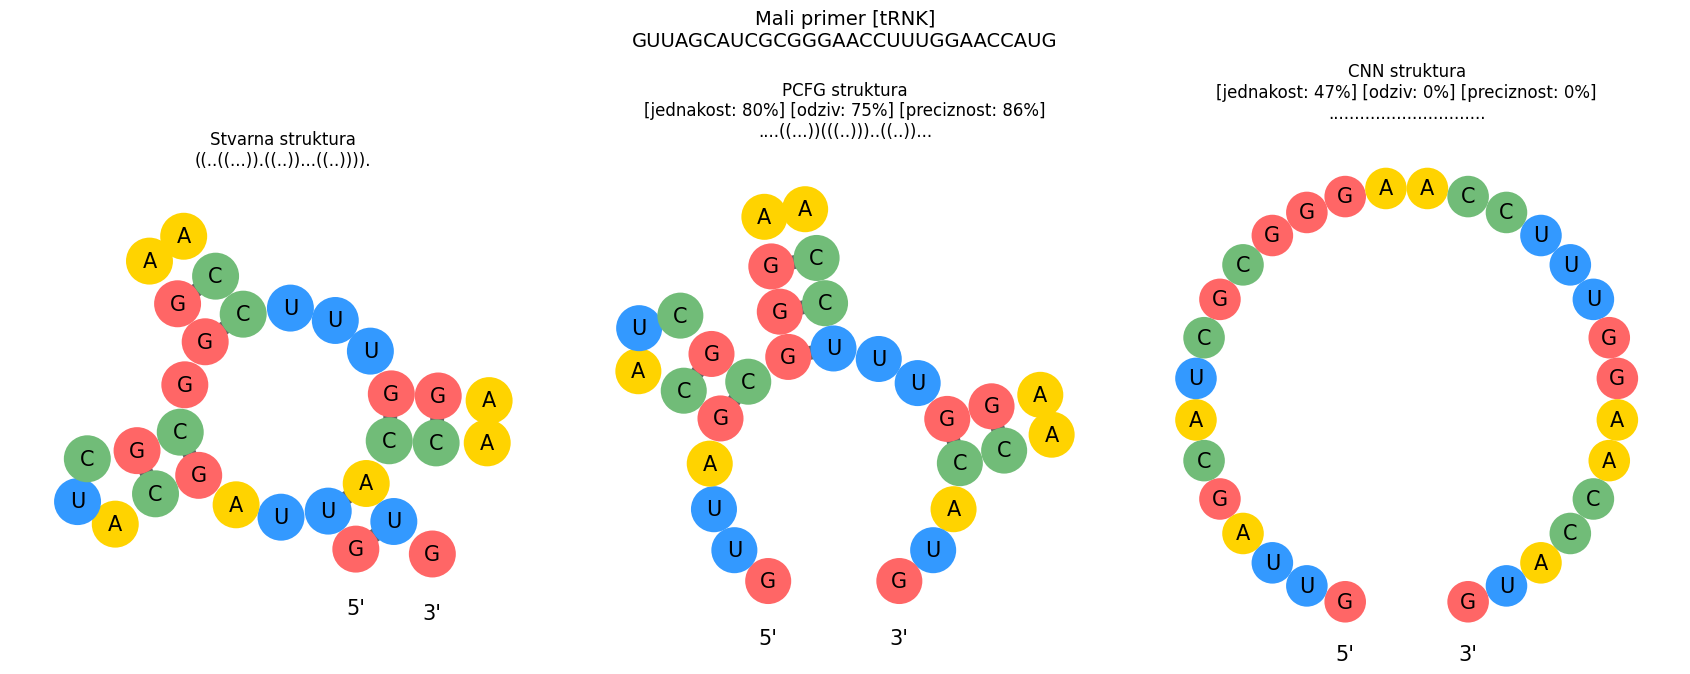

In [99]:
# Predviđanje PCFG na malom primeru
Predikcija(primer)

U nastavku su predviđene strukture svake sekvence iz skupa za test, kao i sačuvane na disku za kasniju upotrebu. Sačuvane su i sve slike radi poređenja.

In [100]:
# Predviđanje strukture nad test skupom
predviđanja = [Predikcija(t) for t in tqdm(test)]

100%|██████████| 858/858 [00:00<00:00, 1485.79it/s]


### 4.5 Ukupni uspeh [⮭]<a id="par:rez"></a>

[⮭]: #par:eval

Kako su sada određena sva predviđanja i izračunate sve mere, mogu se zajedno prikazati. Svi rezultati tabelirani su tako da redovi predstavljaju pojedinačne *RNK*, dok su kolone mere nad instancom. Poslednji red skladišti proseke na celom skupu. Stohastička gramatika *KH-99* pogađa više od četvrtine tačnih struktura ($\sim 28\%$), što nije previše, ali je visokog odziva i preciznosti (oba $\sim 86\%$), što su mnogo relevantnije mere. S druge strane, konvolutivna neuronska mreža skoro je nepogrešiva na odabranom podskupu: pogađa veliku većinu ($\sim 88\%$) tačnih struktura, sa izuzetno visokim odzivom i preciznošću ($>98\%$).

In [101]:
# Biblioteka za Dekartov proizvod
from itertools import product

# Procentualni prikaz svih realnih brojeva
pd.set_option('display.float_format', '{:.2%}'.format)

In [102]:
# Spisak svih kolona tabele
kolone = [*map(''.join, product(['pcfg', 'cnn'], '_', ['jed', 'odz', 'prec', 'f1', 'isti']))]

# Tabeliranje prosleđenog skupa
def tabeliraj(rnk):
    # Prazna tabela sa odgovarajućim kolonama
    tabela = pd.DataFrame(columns=kolone)
    
    # Sortiranje prema identifikatoru
    rnk.sort(key=lambda r: r.id)

    # Tabeliranje prosleđenih RNK
    for r in rnk:
        tabela.loc[r.id] = [getattr(r, k) for k in kolone]
    
    # Pretvaranje svega u objekte
    tabela = tabela.astype('object')
    
    # Izračuvanje proseka svih mera
    tabela.loc[''] = tabela.mean()

    # Upisivanje na lokal za ubuduće
    with fopen(f'../podaci/uspeh.csv') as f:
        tabela.to_csv(f)
    
    # Prikaz izračunate tabele
    display(tabela)

In [103]:
# Tabeliranje rezultata na test skupu
tabeliraj(predviđanja)

,pcfg_jed,pcfg_odz,pcfg_prec,pcfg_f1,pcfg_isti,cnn_jed,cnn_odz,cnn_prec,cnn_f1,cnn_isti
tdbD00000008,100.00%,100.00%,100.00%,100.00%,True,100.00%,100.00%,100.00%,100.00%,True
tdbD00000017,100.00%,100.00%,100.00%,100.00%,True,100.00%,100.00%,100.00%,100.00%,True
tdbD00000019,94.52%,100.00%,91.30%,95.45%,False,100.00%,100.00%,100.00%,100.00%,True
tdbD00000024,69.44%,57.14%,57.14%,57.14%,False,100.00%,100.00%,100.00%,100.00%,True
tdbD00000039,75.00%,71.43%,65.22%,68.18%,False,100.00%,100.00%,100.00%,100.00%,True
...,...,...,...,...,...,...,...,...,...,...
tdbD00012057,73.97%,72.73%,80.00%,76.19%,False,100.00%,100.00%,100.00%,100.00%,True
tdbD00012078,94.67%,100.00%,91.67%,95.65%,False,100.00%,100.00%,100.00%,100.00%,True
tdbD00012082,67.06%,50.00%,52.17%,51.06%,False,100.00%,100.00%,100.00%,100.00%,True
tdbD00012095,56.58%,54.55%,54.55%,54.55%,False,100.00%,100.00%,100.00%,100.00%,True


## 5. Zaključak [⮭]<a id="par:zaklj"></a>

[⮭]: #par:toc

U radu je razmotrena primena probabilističkih kontekstno slobodnih gramatika (*PCFG*) i konvolutivnih neuronskih mreža (*CNN*) u predviđanju sekundarne strukture ribonukleinske kiseline (*RNK*). Preuzet je skup *RNK* sa pridruženim strukturama, nakon čega je na delu podataka obučena po jedna stohastička gramatika i duboka konvolutivna mreža. Modeli su vrednovani prema uspehu na drugom delu podataka, odnosno sličnosti predviđanja sa stvarnošću.

U prvoj glavi, koja je uvodnog tipa, za početak je predstavljen kratak teorijski osvrt na strukturu *RNK*, a zatim na njenu predikciju. Nadalje je opisan referentni skup podataka *RNAStralign*, koji je korišćen prilikom modelovanja. Naposletku je problem olakšan ograničavanjem samo na kratke sekvence, kako bi se izbegli problemi sa računskom zahtevnošću, ali uz zadržavanje biološkog smisla zadatka. U drugoj glavi je uveden pojam stohastičkih kontekstno slobodnih gramatika, sa fokusom na gramatiku *KH-99*. U trećoj glavi je detaljno opisana primenjena duboka konvolutivna arhitektura. Posebna pažnja sve vreme je usmerena na različite mogućnosti reprezentacije ulazne sekvence i izlazne sekundarne strukture: grafovi, nizovi, niske, matrice, mape, tenzori...

Četvrto poglavlje posvećeno je evaluaciji modela. Navedeni su načini na koji se od izlaza modela dobija konačna konkretna i korektna sekundarna struktura, nakon čega su opisane mere kvaliteta modela, odnosno način upoređivanja predviđene strukture sa stvarnom. Sva predviđanja i izračunate mere sačuvani su na disku, ali i grafički prikazani, kako bi se mogli uporediti. Očekivano, *CNN* postiže veći uspeh od *PCFG*. Mreža, ipak, uči znatno više parametara, pa njeno obučavanje i traje duže. Složenost predviđanja u oba slučajeva je kubna u odnosu na dužinu sekvence, što je posledica arhitekture modela. Gramatika pritom parsira samu sekvencu, dok mreža operiše sa kvadratnom matricom mogućnosti uparivanja. Možda glavna prednost neuronske mreže jeste što istovremeno predviđa i neugnežđene interakcije (pseudočvorove), koje zadiru u više nivoe strukturne organizacije *RNK*, a gramatika isključivo ugnežđena uparivanja.